# Packages

**Objectifs**
- Prouver en quoi LightGBM fait mieux en termes d'explicabilité que le modèle régression linéaire et RIDGE pour l'évolution du chômage
- Prouver que LightGBM fait mieux pour tous les modèles en prévision 

**Démarche**
- Etablir le dataframe des résultats
- Analyser la performance prédictive des modèles : 
** Comparaison graphique des données de test et de prévision ; 
** Analyse des erreurs ; 
- Mesurer l'importance des prédicateurs
** Calcul de Mean permutation values (absolute error)
** Calcul de Mean permutation values (Deviance)
** Calcul de Shapley share
- Présentation graphique des métriques d'importances de covariables
- Test de validation des variables importantes
- Expliquer comment les covariables déterminent le taux de chômage

**Résultats**
es premiers résultats montrent que le cycle économique demeure le principal déterminant du chômage : la hausse du crédit, de la demande et de la production réduit le chômage futur, tandis qu’une récession ou une baisse du S&P 500 l’augmente. Toutefois, la forte corrélation entre ces variables suggère une multicolinéarité, pouvant biaiser la régression linéaire.

L’introduction du modèle Ridge vise à corriger ce biais en régularisant les coefficients et en stabilisant les estimations. Le modèle LightGBM, quant à lui, va plus loin en captant les relations non linéaires et les interactions complexes entre les variables macroéconomiques. Il permettra notamment d’évaluer si, au-delà du seul cycle économique, les facteurs monétaires (M2SL) et financiers (S&P 500, BUSLOANS) jouent un rôle significatif dans la dynamique du chômage.

Ces approches permettront donc de dépasser les limites du modèle linéaire et d’obtenir une compréhension plus fine et réaliste du lien entre cycle, politique monétaire et emploi.

**Rapprochement des résultats en théorie économique**

Les résultats confirment la perspective keynésienne, selon laquelle le chômage est avant tout déterminé par le cycle économique : la hausse de la demande, du crédit et de la production favorise l’emploi, tandis qu’une récession accroît le chômage. Le modèle Ridge consolide ces résultats en corrigeant la multicolinéarité entre les variables cycliques, offrant ainsi des estimations plus stables et cohérentes.

Le modèle LightGBM enrichit cette lecture en révélant des relations non linéaires entre les facteurs réels, financiers et monétaires. Il montre notamment que les effets de la politique monétaire (M2, taux courts) ne sont pas uniformes : une expansion modérée soutient l’activité, mais un excès de liquidité peut entraîner des déséquilibres et une remontée du chômage. Ces résultats s’inscrivent dans une approche néo-keynésienne et monétariste, où le chômage résulte d’interactions complexes entre cycle économique, conditions financières et régimes de politique monétaire.

**Limites et Perspectives**

Bien que LightGBM améliore la précision du modèle en captant des relations non linéaires, il présente certaines limites. Il tend d'une part à minimiser l’impact des variables financières telles que S&P 500 et BUSLOANS. D'autre part, il surestime l’effet de OILPRICEx et RPI. Le modèle reste également sensible aux périodes de crise, ce qui peut affecter la stabilité des relations structurelles.

Pour approfondir l’analyse, il serait pertinent de tester LightGBM avec des retards du taux de chômage (lags de UNRATE) afin de mieux intégrer la dynamique temporelle. Par ailleurs, l’utilisation d’outils d’exploration complémentaires permettrait de déterminer plus précisément les points d’inflexion dans les relations non linéaires, par exemple pour évaluer à partir de quel seuil l’expansion monétaire (M2SL) cesse de stimuler l’emploi pour la fin de 2025.


In [1]:
# ==========================================
# Chargement
# ==========================================
import os
import pickle
import joblib
import numpy as np
import pandas as pd

from __future__ import annotations
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Chargement des résultats

In [2]:
# ---------- Helpers ----------

def load_any(path):
    """Charge un objet avec joblib puis pickle si besoin."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")
    try:
        return joblib.load(path)
    except Exception:
        with open(path, "rb") as f:
            return pickle.load(f)

def load_with_fallbacks(primary_path, *alt_paths, expect_type=None, label=None):
    """
    Charge primary_path puis essaie les alt_paths en fallback.
    - expect_type: type attendu (ex: dict), si fourni on vérifie isinstance.
    - label: nom lisible pour logs (ex: 'Ridge bundle OOS').
    """
    name = f" ({label})" if label else ""
    try:
        obj = load_any(primary_path)
        if expect_type and not isinstance(obj, expect_type):
            print(f"⚠️ Type inattendu{name} pour {primary_path}: {type(obj)} (attendu {expect_type}).")
        else:
            return obj
    except Exception as e:
        print(f"ℹ️ Impossible de charger {primary_path}{name} : {e}")

    for p in alt_paths:
        try:
            obj = load_any(p)
            print(f"ℹ️ Fallback utilisé{name} → {p}")
            if expect_type and not isinstance(obj, expect_type):
                print(f"⚠️ Type inattendu{name} pour {p}: {type(obj)} (attendu {expect_type}).")
            return obj
        except Exception as e:
            print(f"ℹ️ Fallback raté{name} → {p} : {e}")

    print(f"⚠️ Aucun fichier disponible{name} (essayé: {[primary_path, *alt_paths]})")
    return None

def try_read_meta(path):
    """Lit un CSV méta. Tente index_col=0 puis sans index si échec."""
    for use_index in (0, None):
        try:
            meta = pd.read_csv(path, index_col=use_index)
            # Si 1 colonne, exposer Series
            if isinstance(meta, pd.DataFrame) and meta.shape[1] == 1:
                meta = meta.iloc[:, 0]
            return meta
        except Exception as e:
            last_err = e
    print(f"⚠️ Impossible de lire {path} : {last_err}")
    return None

def safe_meta_print(meta, keys, title="Méta"):
    """Affiche les clés demandées sans lever d'erreur si elles manquent."""
    if meta is None:
        print("⚠️ Pas de méta disponible.")
        return
    if isinstance(meta, pd.Series):
        d = meta.to_dict()
    elif isinstance(meta, pd.DataFrame):
        d = meta.iloc[0].to_dict() if len(meta) else {}
    elif isinstance(meta, dict):
        d = meta
    else:
        print(f"(info) Type de méta inattendu: {type(meta)}")
        d = {}

    print(f"\n--- {title} (clé: valeur) ---")
    for k in keys:
        print(f"{k}: {d.get(k, None)}")

def _normalize_month_start(s):
    s = pd.to_datetime(s, errors="coerce")
    if isinstance(s, pd.Series):
        return s.dt.to_period("M").dt.to_timestamp(how="start")
    if isinstance(s, pd.DatetimeIndex):
        return s.to_period("M").to_timestamp(how="start")
    return pd.Timestamp(s).to_period("M").to_timestamp(how="start")

def ensure_ms_index_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.index = pd.to_datetime(out.index).to_period("M").to_timestamp(how="start")
    return out.sort_index().asfreq("MS")

def ensure_features_present(df: pd.DataFrame, features: list[str], target_col: str | None = None):
    missing = [c for c in (features or []) if c not in df.columns]
    if target_col is not None and target_col not in df.columns:
        missing.append(target_col)
    if missing:
        raise ValueError(f"Colonnes manquantes dans le DataFrame: {missing}")

def make_exp_from_loaded(*, models, features, train_periods, preprocs=None, step_months: int = 12) -> dict:
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise ValueError("'models' doit être une liste non vue.")
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("'features' doit être une liste non vide.")
    if not isinstance(train_periods, (list, tuple)) or len(train_periods) != len(models):
        raise ValueError("'train_periods' doit avoir la même longueur que 'models'.")
    if preprocs is not None and len(preprocs) != len(models):
        raise ValueError("'preprocs' doit avoir la même longueur que 'models' si fourni.")
    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   int(step_months),
    }

def exp_from_linreg_bundle_no_refit(linreg_bundle: dict) -> dict:
    if not isinstance(linreg_bundle, dict):
        raise ValueError("linreg_bundle invalide (pas un dict).")
    params = linreg_bundle.get("params", {}) or {}
    features = params.get("features", linreg_bundle.get("features", None))
    if not features:
        raise ValueError("Features absentes dans le bundle (params.features).")
    models = linreg_bundle.get("models", None)
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise RuntimeError(
            "Ce bundle ne contient pas la liste des modèles par fenêtre ('models'). "
            "Sauvegarde les modèles lors de l'apprentissage, puis recharge."
        )
    preprocs = linreg_bundle.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise RuntimeError("'preprocs' n'a pas la même longueur que 'models'.")
    train_periods = linreg_bundle.get("train_fit_dates", None)
    if train_periods is None or len(train_periods) != len(models):
        raise RuntimeError("'train_fit_dates' manquant ou de longueur différente de 'models'.")
    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   12,
    }

def extract_last_model_from_bundle(bundle: dict, model_key="models"):
    """Récupère le dernier modèle depuis un bundle, sinon None."""
    try:
        if isinstance(bundle, dict) and model_key in bundle and bundle[model_key]:
            return bundle[model_key][-1]
    except Exception as e:
        print(f"⚠️ Impossible d'extraire le dernier modèle: {e}")
    return None

In [3]:
# ---------- Fichiers ----------
AR1_LAST_PKL  = "AR1_last_trained_model.pkl"
AR1_LAST_META = "AR1_last_trained_model_meta.csv"
AR1_BUNDLE    = "AR1_h12_oos_bundle.pkl"

LINREG_PKL    = "linear_regression.pkl"
LINREG_META   = "linear_regression_meta.csv"

# 🔹 AR(p)
ARP_LAST_PKL  = "ARP_last_trained_model.pkl"
ARP_LAST_META = "ARP_last_trained_model_meta.csv"
ARP_BUNDLE    = "ARP_h12_oos_bundle.pkl"

# 🔹 Ridge
RIDGE_LAST_PKL  = "RIDGE_last_trained_model.pkl"
RIDGE_LAST_META = "RIDGE_last_trained_model_meta.csv"
RIDGE_BUNDLE    = "RIDGE_h12_oos_bundle.pkl"
RIDGE_PKL       = "ridge_regression.pkl"
RIDGE_META      = "ridge_regression_meta.csv"

# 🔹 LightGBM
LGBM_LAST_PKL   = "LGBM_last_trained_model.pkl"
LGBM_LAST_META  = "LGBM_last_trained_model_meta.csv"
LGBM_BUNDLE     = "LGBM_h12_oos_bundle.pkl"
LGBM_PKL        = "lightgbm_regression.pkl"
LGBM_META       = "lightgbm_regression_meta.csv"


In [4]:
# ============= CHARGEMENTS COMPLETS =============

print("=== Chargement AR(1) ===")
try:
    ar1_model = load_any(AR1_LAST_PKL)
    print("✅ Modèle AR(1) chargé.")
except Exception as e:
    ar1_model = None
    print(f"⚠️ Modèle AR(1) non chargé : {e}")
ar1_meta  = try_read_meta(AR1_LAST_META)

try:
    ar1_bundle = load_any(AR1_BUNDLE)
    print("✅ Bundle AR(1) chargé (OOS h=12).")
except Exception as e:
    ar1_bundle = None
    print(f"⚠️ Bundle AR(1) non chargé : {e}")

print("\n=== Chargement AR(p) ===")
try:
    arp_model = load_any(ARP_LAST_PKL)
    print("✅ Modèle AR(p) chargé.")
except Exception as e:
    arp_model = None
    print(f"⚠️ Modèle AR(p) non chargé : {e}")
arp_meta = try_read_meta(ARP_LAST_META)

try:
    arp_bundle = load_any(ARP_BUNDLE)
    print("✅ Bundle AR(p) chargé (OOS h=12).")
except Exception as e:
    arp_bundle = None
    print(f"⚠️ Bundle AR(p) non chargé : {e}")

print("\n=== Chargement Régression Linéaire ===")
try:
    linreg_bundle = load_any(LINREG_PKL)   # dict avec 'oos_predictions', 'params', etc.
    print("✅ Régression linéaire chargée.")
except Exception as e:
    linreg_bundle = None
    print(f"⚠️ Régression linéaire non chargée : {e}")
linreg_meta = try_read_meta(LINREG_META)

# ------------------------------------------------------------------
# 🔹 Ridge
print("\n=== Chargement Ridge ===")
# Bundle principal (comme LINREG_PKL)
try:
    ridge_bundle = load_any(RIDGE_PKL)
    print("✅ Ridge (bundle principal) chargé.")
except Exception as e:
    ridge_bundle = None
    print(f"⚠️ Ridge (bundle principal) non chargé : {e}")
ridge_meta = try_read_meta(RIDGE_META)

# Dernier modèle entraîné (artefact)
try:
    ridge_model = load_any(RIDGE_LAST_PKL)
    print("✅ Modèle Ridge (dernier fit) chargé.")
except Exception as e:
    ridge_model = None
    print(f"⚠️ Modèle Ridge non chargé : {e}")

# Bundle OOS h=12 optionnel (si distinct du bundle principal)
try:
    ridge_oos_bundle = load_any(RIDGE_BUNDLE)
    print("✅ Bundle Ridge OOS (h=12) chargé.")
except Exception as e:
    ridge_oos_bundle = None
    print(f"⚠️ Bundle Ridge OOS non chargé : {e}")

# ------------------------------------------------------------------
# 🔹 LightGBM
print("\n=== Chargement LightGBM ===")
# Bundle principal
try:
    lgbm_bundle = load_any(LGBM_PKL)
    print("✅ LightGBM (bundle principal) chargé.")
except Exception as e:
    lgbm_bundle = None
    print(f"⚠️ LightGBM (bundle principal) non chargé : {e}")
lgbm_meta = try_read_meta(LGBM_META)

# Dernier modèle entraîné (artefact)
try:
    lgbm_model = load_any(LGBM_LAST_PKL)
    print("✅ Modèle LightGBM (dernier fit) chargé.")
except Exception as e:
    lgbm_model = None
    print(f"⚠️ Modèle LightGBM non chargé : {e}")

# Bundle OOS h=12 optionnel (si distinct du bundle principal)
try:
    lgbm_oos_bundle = load_any(LGBM_BUNDLE)
    print("✅ Bundle LightGBM OOS (h=12) chargé.")
except Exception as e:
    lgbm_oos_bundle = None
    print(f"⚠️ Bundle LightGBM OOS non chargé : {e}")

=== Chargement AR(1) ===
✅ Modèle AR(1) chargé.
✅ Bundle AR(1) chargé (OOS h=12).

=== Chargement AR(p) ===
✅ Modèle AR(p) chargé.
✅ Bundle AR(p) chargé (OOS h=12).

=== Chargement Régression Linéaire ===
✅ Régression linéaire chargée.

=== Chargement Ridge ===
✅ Ridge (bundle principal) chargé.
⚠️ Modèle Ridge non chargé : Fichier introuvable: RIDGE_last_trained_model.pkl
⚠️ Bundle Ridge OOS non chargé : Fichier introuvable: RIDGE_h12_oos_bundle.pkl

=== Chargement LightGBM ===
✅ LightGBM (bundle principal) chargé.
✅ Modèle LightGBM (dernier fit) chargé.
⚠️ Bundle LightGBM OOS non chargé : Fichier introuvable: LGBM_h12_oos_bundle.pkl


In [5]:
# ------------------------------------------------------------------
# 🔹 Ridge
print("\n=== Chargement Ridge ===")
ridge_bundle = load_with_fallbacks(
    RIDGE_PKL,             # bundle principal
    RIDGE_BUNDLE,          # alias OOS si tu l'as
    expect_type=dict,
    label="Ridge bundle"
)
ridge_meta = try_read_meta(RIDGE_META)

ridge_model = load_with_fallbacks(
    RIDGE_LAST_PKL,
    label="Ridge dernier modèle"
)
if ridge_model is None and ridge_bundle:
    ridge_model = extract_last_model_from_bundle(ridge_bundle, model_key="models")
    if ridge_model is not None:
        print("ℹ️ Ridge: dernier modèle reconstruit depuis ridge_bundle['models'][-1].")

ridge_oos_bundle = load_with_fallbacks(
    RIDGE_BUNDLE, RIDGE_PKL,
    expect_type=dict,
    label="Ridge OOS"
)

# ------------------------------------------------------------------
# 🔹 LightGBM
print("\n=== Chargement LightGBM ===")
lgbm_bundle = load_with_fallbacks(
    LGBM_PKL,
    LGBM_BUNDLE,
    expect_type=dict,
    label="LightGBM bundle"
)
lgbm_meta = try_read_meta(LGBM_META)

lgbm_model = load_with_fallbacks(
    LGBM_LAST_PKL,
    label="LightGBM dernier modèle"
)
if lgbm_model is None and lgbm_bundle:
    lgbm_model = extract_last_model_from_bundle(lgbm_bundle, model_key="models")
    if lgbm_model is not None:
        print("ℹ️ LightGBM: dernier modèle reconstruit depuis lgbm_bundle['models'][-1].")

lgbm_oos_bundle = load_with_fallbacks(
    LGBM_BUNDLE, LGBM_PKL,
    expect_type=dict,
    label="LightGBM OOS"
)


=== Chargement Ridge ===
ℹ️ Impossible de charger RIDGE_last_trained_model.pkl (Ridge dernier modèle) : Fichier introuvable: RIDGE_last_trained_model.pkl
⚠️ Aucun fichier disponible (Ridge dernier modèle) (essayé: ['RIDGE_last_trained_model.pkl'])
ℹ️ Ridge: dernier modèle reconstruit depuis ridge_bundle['models'][-1].
ℹ️ Impossible de charger RIDGE_h12_oos_bundle.pkl (Ridge OOS) : Fichier introuvable: RIDGE_h12_oos_bundle.pkl
ℹ️ Fallback utilisé (Ridge OOS) → ridge_regression.pkl

=== Chargement LightGBM ===
ℹ️ Impossible de charger LGBM_h12_oos_bundle.pkl (LightGBM OOS) : Fichier introuvable: LGBM_h12_oos_bundle.pkl
ℹ️ Fallback utilisé (LightGBM OOS) → lightgbm_regression.pkl


# Etablir de dataframe des résultats.

In [6]:
# =============== STANDARDISATION ===============
def standardize_oos_predictions(
    oos: pd.DataFrame,
    *,
    method_name: str | None = None,
    date_candidates=("date","dates"),
    true_candidates=("y_true","true","target","y"),
    pred_candidates=("y_pred","pred","prediction","forecast","yhat"),
) -> pd.DataFrame:
    """
    Convertit un DataFrame OOS quelconque en colonnes standardisées: (date, true, pred[, method]).
    - Ne dépend d'aucun modèle particulier.
    - Suppose que oos contient au moins une des colonnes candidates pour date/true/pred.
    """
    d = oos.copy()
    if d.index.name is not None:
        d = d.reset_index()

    cols = {c.lower(): c for c in d.columns}
    def _pick(cands):
        for k in cands:
            if k in cols:
                return cols[k]
        return None

    date_col = _pick(date_candidates)
    true_col = _pick(true_candidates)
    pred_col = _pick(pred_candidates)
    if not (date_col and true_col and pred_col):
        raise ValueError(f"Colonnes manquantes (date/true/pred) dans {d.columns.tolist()}")

    out = d[[date_col, true_col, pred_col]].rename(columns={date_col:"date", true_col:"true", pred_col:"pred"})
    out["date"] = _normalize_month_start(out["date"])
    if method_name:
        out["method"] = method_name
    return out.reset_index(drop=True)

In [7]:
def build_df_from_bundle(bundle: dict, default_method: str = "Model") -> pd.DataFrame:
    """
    Extrait/standardise 'oos_predictions' depuis un bundle générique.
    - Bundle attendu: {'oos_predictions': DataFrame, 'params': {'model': ...}, ...}
    - Aucune logique spécifique à un modèle.
    """
    if not isinstance(bundle, dict) or "oos_predictions" not in bundle:
        return pd.DataFrame(columns=["date","true","pred","method"])
    params = bundle.get("params", {}) or {}
    method = params.get("model", default_method)
    return standardize_oos_predictions(bundle["oos_predictions"], method_name=method)

In [8]:
def assemble_long_from_bundles(*bundles: dict) -> pd.DataFrame:
    """
    Fusionne un nombre quelconque de bundles génériques en un long DataFrame homogène.
    Colonnes finales: (date, true, pred, method).
    """
    dfs = [build_df_from_bundle(b) for b in bundles if isinstance(b, dict)]
    dfs = [d for d in dfs if not d.empty]
    if not dfs:
        return pd.DataFrame(columns=["date","true","pred","method"])
    out = pd.concat(dfs, ignore_index=True)
    out["date"] = pd.to_datetime(out["date"], errors="coerce")
    out = out.dropna(subset=["date","true","pred"]).sort_values(["date","method"]).reset_index(drop=True)
    return out

In [9]:
# =================== SCORES ====================
def scores_basic(df: pd.DataFrame) -> dict[str, float]:
    """
    Calcule MAE, RMSE, R2 sur un DataFrame standardisé (date,true,pred[,method]).
    Totalement générique.
    """
    if df.empty:
        return {"MAE": np.nan, "RMSE": np.nan, "R2": np.nan}
    mae  = float(mean_absolute_error(df["true"], df["pred"]))
    rmse = float(np.sqrt(mean_squared_error(df["true"], df["pred"])))
    r2   = float(r2_score(df["true"], df["pred"])) if len(df) > 1 else np.nan
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def scores_by_method_and_window(
    df_long: pd.DataFrame,
    eval_window=("1983-01-01","1989-12-31"),
    test_window=("1990-01-01","2025-12-31"),
) -> dict[str, dict[str, dict[str, float]]]:
    """
    Scores par méthode pour deux fenêtres (Validation/Test).
    N’emploie aucun modèle spécifique.
    """
    if df_long.empty:
        return {"validation": {}, "test": {}}
    df = df_long.copy()
    df["date"] = pd.to_datetime(df["date"])
    e0, e1 = map(pd.Timestamp, eval_window)
    t0, t1 = map(pd.Timestamp, test_window)

    out = {"validation": {}, "test": {}}
    for m in sorted(df["method"].unique()):
        dval = df[(df["method"]==m) & (df["date"]>=e0) & (df["date"]<=e1)]
        dtes = df[(df["method"]==m) & (df["date"]>=t0) & (df["date"]<=t1)]
        out["validation"][m] = scores_basic(dval)
        out["test"][m]       = scores_basic(dtes)
    return out

In [10]:
# ============== OOS EXPANDING (générique) ==============
def oos_expanding_predict(
    *,
    y: pd.Series,
    X: pd.DataFrame | None = None,   # None = univarié ; sinon multivarié
    h: int = 12,
    min_train_n: int = 36,
    model_factory,                   # callable -> objet modèle avec fit(...) et predict(...)
    preproc_fit_fn=None,             # callable(X_train) -> (X_train_proc, prep)
    preproc_apply_fn=None,           # callable(X, prep) -> X_proc
    y_transform=None,                # callable(y) -> y_t
    y_inverse=None,                  # callable(y_t) -> y
    method_name: str = "Model",
) -> pd.DataFrame:
    """
    Moteur PSEUDO-OOS rolling-origin (expanding) **générique**.
    - Aucun modèle imposé : injecte ton modèle via `model_factory`.
    - `X` optionnel: univarié si None, multivarié sinon.
    - `preproc_fit_fn` et `preproc_apply_fn` optionnels (winsor/norm ou autre).
    - `y_transform`/`y_inverse` optionnels (différenciation, log, etc.).
    """
    # Alignement indices (MS)
    y = y.astype(float).copy()
    y.index = pd.to_datetime(y.index).to_period("M").to_timestamp(how="start")
    y = y.asfreq("MS")
    if X is not None:
        X = X.astype(float).copy()
        X.index = pd.to_datetime(X.index).to_period("M").to_timestamp(how="start")
        X = X.asfreq("MS")
        X, y = X.align(y, join="inner")

    rows = []
    last_t_end = y.index.max() - relativedelta(months=h)

    for t_end in y.index:
        if t_end > last_t_end:
            break
        y_tr = y.loc[:t_end]
        if len(y_tr) < min_train_n:
            continue

        X_tr = X.loc[:t_end] if X is not None else None
        y_tr_fit = y_transform(y_tr) if y_transform else y_tr

        if X_tr is not None and preproc_fit_fn:
            X_tr_p, prep = preproc_fit_fn(X_tr)
        else:
            X_tr_p, prep = (X_tr, None)

        model = model_factory()
        if X_tr_p is None:
            # univarié: le wrapper du modèle doit offrir .fit(y_series)
            model.fit(y_tr_fit)
        else:
            model.fit(X_tr_p, y_tr_fit.values)

        t_fore = t_end + relativedelta(months=h)
        if t_fore in y.index:
            if X is not None:
                x_fore_raw = X.loc[[t_fore]]
                x_fore_p = preproc_apply_fn(x_fore_raw, prep) if (preproc_apply_fn and prep is not None) else x_fore_raw
                yhat_h = float(model.predict(x_fore_p)[0])
            else:
                # univarié: le wrapper doit offrir predict(y_full, t_end, h)
                yhat_h = float(model.predict(y, t_end=t_end, h=h))

            if y_inverse:
                yhat_h = float(y_inverse(pd.Series([yhat_h], index=[t_fore]))[0])

            rows.append((t_fore, float(y.loc[t_fore]), yhat_h))

    out = pd.DataFrame(rows, columns=["date","true","pred"]).sort_values("date")
    out["date"] = _normalize_month_start(out["date"])
    out["method"] = method_name
    return out.reset_index(drop=True)

In [11]:
# ========= Standardisation & fusion (générique, sans modèle spécifique) =========
# Inclure TOUS les bundles disponibles : AR(1), AR(p), LinReg, Ridge, LightGBM
available_bundles = [
    b for b in (ar1_bundle, arp_bundle, linreg_bundle, ridge_bundle, lgbm_bundle)
    if isinstance(b, dict)
]

if len(available_bundles) == 0:
    raise RuntimeError("Aucun bundle disponible parmi AR(1), AR(p), LinearRegression, Ridge, LightGBM.")

# 1) DataFrame long standardisé : (date, true, pred, method)
df_pred_long = assemble_long_from_bundles(*available_bundles)

# (Option) Harmoniser les noms de méthode pour les plots/tableaux
rename_map = {
    "AR(1)": "AR1",
    "AR(p)": "ARP",
    "LinearRegression": "LINREG",
    "Ridge": "RIDGE",
    "Ridge + Bagging": "RIDGE",
    "LightGBM + Bagging": "LightGBM",
}
if "method" in df_pred_long.columns:
    df_pred_long["method"] = df_pred_long["method"].replace(rename_map)

print(f"\n✅ Fusion réussie — df_pred_long shape = {df_pred_long.shape}")
if not df_pred_long.empty:
    print("Méthodes :", sorted(df_pred_long["method"].unique().tolist()))
    print(df_pred_long.head(10))

# 2) Évaluation (fenêtres Validation/Test)
eval_window = ("1983-01-01", "1989-12-31")
test_window = ("1990-01-01", "2025-12-31")

scores = scores_by_method_and_window(
    df_pred_long,
    eval_window=eval_window,
    test_window=test_window,
)

print("\n📊 Scores par méthode")
print("Validation", eval_window, ":", scores["validation"])
print("Test",       test_window, ":", scores["test"])


✅ Fusion réussie — df_pred_long shape = (3705, 4)
Méthodes : ['AR1', 'ARP', 'LINREG', 'LightGBM', 'RIDGE']
        date  true      pred    method
0 1963-12-01   0.0  0.070473       AR1
1 1963-12-01   0.0  0.070473       ARP
2 1963-12-01   0.0 -0.280599  LightGBM
3 1963-12-01   0.0 -0.729972    LINREG
4 1963-12-01   0.0  0.093785     RIDGE
5 1964-01-01  -0.1  0.017682       AR1
6 1964-01-01  -0.1  0.017682       ARP
7 1964-01-01  -0.1  0.178110  LightGBM
8 1964-01-01  -0.1 -0.234660    LINREG
9 1964-01-01  -0.1  0.348080     RIDGE

📊 Scores par méthode
Validation ('1983-01-01', '1989-12-31') : {'AR1': {'MAE': 0.8165429053887817, 'RMSE': 1.2335653335804957, 'R2': -0.948709263073934}, 'ARP': {'MAE': 0.8185346590982996, 'RMSE': 1.1873279642039225, 'R2': -0.805361307662879}, 'LINREG': {'MAE': 0.8149037150628475, 'RMSE': 1.0237021878324808, 'R2': -0.3420540293832697}, 'LightGBM': {'MAE': 0.7992131150856762, 'RMSE': 1.0467430342112398, 'R2': -0.4031461092144488}, 'RIDGE': {'MAE': 0.818999867

In [12]:
def filter_df_by_start_date(df: pd.DataFrame, start_date: str = "1990-01-01") -> pd.DataFrame:
    """
    Filtre un DataFrame standardisé (date, true, pred, method)
    en ne gardant que les observations à partir de `start_date`.
    Retourne un DataFrame trié + index propre.
    """
    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce")

    out = (
        out[out["date"] >= pd.Timestamp(start_date)]
        .sort_values(["date", "method"])
        .reset_index(drop=True)
    )

    print(f"\n✅ Filtrage appliqué — période: {out['date'].min().date()} → {out['date'].max().date()} | n={len(out)}")
    print("Méthodes présentes :", sorted(out["method"].unique().tolist()))
    print("\nAperçu post-filtrage :")
    print(out.head(10))

    return out

In [13]:
df_pred_long = filter_df_by_start_date(df_pred_long, start_date="1990-01-01")


✅ Filtrage appliqué — période: 1990-01-01 → 2025-08-01 | n=2140
Méthodes présentes : ['AR1', 'ARP', 'LINREG', 'LightGBM', 'RIDGE']

Aperçu post-filtrage :
        date  true      pred    method
0 1990-01-01   0.0 -0.092641       AR1
1 1990-01-01   0.0 -0.105509       ARP
2 1990-01-01   0.0 -0.198600    LINREG
3 1990-01-01   0.0 -0.275877  LightGBM
4 1990-01-01   0.0 -0.123126     RIDGE
5 1990-02-01   0.1 -0.050509       AR1
6 1990-02-01   0.1 -0.083438       ARP
7 1990-02-01   0.1 -0.355812    LINREG
8 1990-02-01   0.1 -0.434981  LightGBM
9 1990-02-01   0.1 -0.253089     RIDGE


# Analyser la performance prédictive des modèles

## Comparaison des données de test et de prévision

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_wide_from_long(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Transforme un DataFrame long (date, method, pred, true)
    en un tableau large : une colonne par méthode + la vérité.
    """
    df = df_long.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Valeur "true" médiane par date
    true_by_date = df.groupby("date")["true"].median().rename("true")

    # Moyenne des prédictions par méthode
    wide = df.pivot_table(index="date", columns="method", values="pred", aggfunc="mean").sort_index()
    wide = wide.join(true_by_date, how="left")

    print("✅ wide prêt :", wide.shape, "| Colonnes :", wide.columns.tolist())
    return wide

In [15]:
def make_color_map(methods: list[str]) -> dict:
    """
    Crée une palette de couleurs cohérente pour chaque méthode.
    """
    cmap = {}
    base_colors = plt.cm.get_cmap("tab10", len(methods))
    for i, m in enumerate(methods):
        cmap[m] = base_colors(i)
    cmap["true"] = "white"  # la vérité en blanc (fond noir)
    return cmap

In [16]:
def get_split_dates(segments):
    """
    Extrait les dates de séparation à partir d'une liste de segments :
    [(start, end, label), ...] → liste unique et triée de dates.
    """
    dates = sorted({pd.to_datetime(start) for (start, _, _) in segments})
    return dates

In [17]:
def plot_two_global_charts(
    df_long: pd.DataFrame,
    segments: list[tuple[str, str | None, str]],
    *,
    H: int = 12,
    mode: str = "aligne",   # "aligne" ou "decale"
    save: bool = True,
    title_prefix: str = ""
):
    """
    Trace deux graphiques globaux :
    1) Prévisions des modèles
    2) Évolution des erreurs absolues
    avec les dates de séparation affichées sur les deux.
    """
    plt.style.use("dark_background")

    # --- Construction du wide ---
    wide = build_wide_from_long(df_long)
    wide = wide.dropna(subset=["true"])  # sécurité
    methods = [c for c in wide.columns if c != "true"]
    colors = make_color_map(methods)
    split_dates = get_split_dates(segments)

    # ============================================================
    # 1️⃣  Prévisions des modèles
    # ============================================================
    fig1 = plt.figure(figsize=(12, 5.2))
    plt.plot(wide.index, wide["true"], label="true", color=colors["true"], linewidth=2.2)

    for m in methods:
        if mode == "aligne":
            plt.plot(wide.index, wide[m], label=m, color=colors[m], linewidth=1.5)
        elif mode == "decale":
            plt.plot(wide.index - pd.DateOffset(months=H), wide[m], label=f"{m} (−{H}m)", color=colors[m], linewidth=1.5)
        else:
            raise ValueError("mode inconnu (utiliser 'aligne' ou 'decale')")

    # Lignes verticales (séparations)
    for d in split_dates:
        plt.axvline(d, linestyle="--", alpha=0.6)

    plt.title(f"{title_prefix}Prévisions des modèles (mode={mode}, h={H})".strip())
    plt.xlabel("Date")
    plt.ylabel("Niveau")
    plt.grid(alpha=0.3)
    plt.legend(ncols=2)
    plt.tight_layout()

    if save:
        plt.savefig("global_forecasts.png", dpi=150)
        print("💾 Figure enregistrée → global_forecasts.png")

    plt.show()

    # ============================================================
    # 2️⃣  Évolution des erreurs absolues
    # ============================================================
    errs = pd.DataFrame(
        {m: (wide["true"] - wide[m]).abs() for m in methods},
        index=wide.index
    )

    fig2 = plt.figure(figsize=(12, 5.2))
    for m in methods:
        plt.plot(errs.index, errs[m], label=f"|err| {m}", color=colors[m], linewidth=1.5)

    for d in split_dates:
        plt.axvline(d, linestyle="--", alpha=0.6)

    plt.title(f"{title_prefix}Évolution des erreurs absolues".strip())
    plt.xlabel("Date")
    plt.ylabel("|Erreur|")
    plt.grid(alpha=0.3)
    plt.legend(ncols=2)
    plt.tight_layout()

    if save:
        plt.savefig("global_errors.png", dpi=150)
        print("💾 Figure enregistrée → global_errors.png")

    plt.show()

✅ wide prêt : (428, 6) | Colonnes : ['AR1', 'ARP', 'LINREG', 'LightGBM', 'RIDGE', 'true']


C:\Users\Mita\AppData\Local\Temp\ipykernel_16872\358210771.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colors = plt.cm.get_cmap("tab10", len(methods))


💾 Figure enregistrée → global_forecasts.png


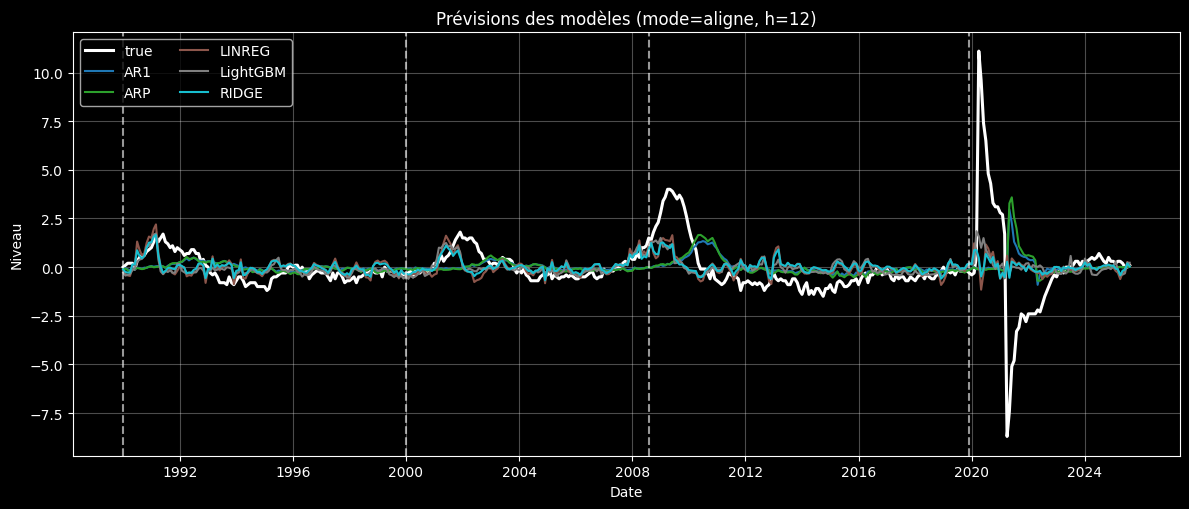

💾 Figure enregistrée → global_errors.png


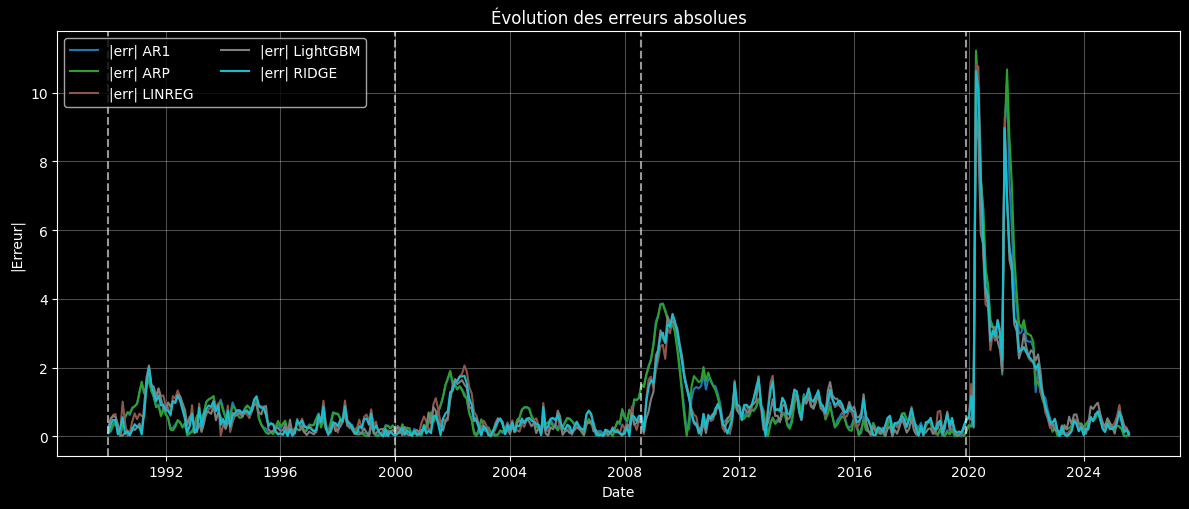

In [18]:
# Fenêtres temporelles
segments = [
    ("1990-01-01", "1999-12-31", "1990-1999"),
    ("2000-01-01", "2008-07-31", "2000-2008"),
    ("2008-08-01", "2019-11-30", "2008-2019"),
    ("2019-12-01", None,         "2019-fin"),
]

# Appel principal → produit 2 figures globales
plot_two_global_charts(
    df_pred_long,
    segments,
    H=12,
    mode="aligne",  # ou "decale"
    save=True,
    title_prefix=""
)

## Analyse des erreurs

In [19]:
import numpy as np
import pandas as pd
from typing import Iterable, Optional, Tuple, List, Dict
from math import sqrt, erf, isfinite

# ============================================================
# 0) Petits utilitaires généraux
# ============================================================

def _ensure_wide(df_wide: pd.DataFrame) -> pd.DataFrame:
    """
    - S'assure que l'index est un DatetimeIndex (ou convertit la colonne 'date' si présente)
    - Trie, vérifie la présence de 'true'
    """
    wide = df_wide.copy()
    if "date" in wide.columns:
        wide["date"] = pd.to_datetime(wide["date"], errors="coerce")
        wide = wide.set_index("date")
    if not isinstance(wide.index, pd.DatetimeIndex):
        raise ValueError("df_wide doit avoir un DatetimeIndex ou une colonne 'date' convertible en datetime.")
    wide = wide.sort_index()
    if "true" not in wide.columns:
        raise ValueError("df_wide doit contenir la colonne 'true'.")
    return wide

def _resolve_methods(wide: pd.DataFrame, methods: Optional[Iterable[str]]) -> List[str]:
    """Renvoie la liste finale des colonnes modèles à évaluer (exclut 'true')."""
    if methods is None:
        return [c for c in wide.columns if c != "true"]
    return [m for m in methods if m in wide.columns and m != "true"]

def _build_windows(
    wide: pd.DataFrame,
    periods: List[Tuple[str, Optional[str], str]],
    *,
    include_overall: bool = True,
    overall_label: str = "Ensemble",
) -> List[Tuple[pd.Timestamp, pd.Timestamp, str]]:
    """Construit la liste des fenêtres (start, end, label), avec 'Ensemble' en premier si demandé."""
    full_start, full_end = wide.index.min(), wide.index.max()
    windows: List[Tuple[pd.Timestamp, pd.Timestamp, str]] = []
    if include_overall:
        windows.append((full_start, full_end, overall_label))
    for start, end, label in periods:
        s = pd.to_datetime(start)
        e = pd.to_datetime(end) if end is not None else full_end
        windows.append((s, e, label))
    return windows

In [20]:
# ============================================================
# 1) Calcul des MAE & erreurs par fenêtre
# ============================================================

def _mae_and_errors_for_window(
    sub: pd.DataFrame,
    methods: List[str],
    *,
    min_obs: int = 20,
) -> Tuple[Dict[str, float], Dict[str, pd.Series]]:
    """
    Renvoie:
      - maes:    {model -> MAE} (NaN si pas assez d'observations)
      - err_abs: {model -> série |true - pred| alignée sur l'index de sub}
    """
    maes: Dict[str, float] = {}
    err_abs: Dict[str, pd.Series] = {}
    for m in methods:
        diffs = (sub["true"] - sub[m]).abs()
        valid = diffs.dropna()
        err_abs[m] = valid
        maes[m] = float(valid.mean()) if valid.shape[0] >= min_obs else np.nan
    return maes, err_abs

In [21]:
# ============================================================
# 2) Test de Diebold–Mariano (version sans SciPy)
# ============================================================

def _phi(z: float) -> float:
    """CDF N(0,1)."""
    return 0.5 * (1.0 + erf(z / sqrt(2.0)))

def _dm_pvalue(diff: np.ndarray, lags: int = 0) -> float:
    """
    p-value bilatérale du test DM avec variance HAC (poids de Bartlett).
    diff = l_t = loss_model - loss_best (ici MAE via erreurs absolues).
    lags=0 : erreurs 1-step non chevauchées (cas le plus simple).
    """
    x = np.asarray(diff, dtype=float)
    x = x[np.isfinite(x)]
    T = x.size
    if T < 3:
        return np.nan

    dbar = x.mean()
    gamma0 = np.dot(x - dbar, x - dbar) / T
    var = gamma0
    if lags > 0:
        for k in range(1, min(lags, T - 1) + 1):
            w = 1.0 - k / (lags + 1.0)
            cov = np.dot(x[k:] - dbar, x[:-k] - dbar) / T
            var += 2.0 * w * cov
    if var <= 0:
        return np.nan

    stat = dbar / sqrt(var / T)
    p = 2.0 * (1.0 - _phi(abs(stat)))
    return max(0.0, min(1.0, p))

In [22]:

# ============================================================
# 3) Formatage cellule "MAE (p)" par fenêtre
# ============================================================

def _format_cells_for_window(
    sub: pd.DataFrame,
    methods: List[str],
    maes: Dict[str, float],
    err_abs: Dict[str, pd.Series],
    *,
    min_obs: int,
    add_dm: bool,
    dm_lags: int,
    show_p_for_best: bool,
    round_digits: int,
    label_map: Optional[Dict[str, str]] = None,
) -> List[Tuple[str, str]]:
    """
    Pour une fenêtre donnée, retourne une liste [(model_label, cell_text), ...]
    où cell_text = "MAE" ou "MAE (p)".
    """
    # Trouver le meilleur modèle sur la fenêtre (MAE minimale)
    finite_models = [m for m in methods if isfinite(maes.get(m, np.nan))]
    best_m = min(finite_models, key=lambda m: maes[m]) if finite_models else None

    out: List[Tuple[str, str]] = []
    for m in methods:
        label = label_map.get(m, m) if label_map else m
        mae_val = maes.get(m, np.nan)

        if not isfinite(mae_val):
            out.append((label, np.nan))
            continue

        p_txt = ""
        if add_dm and best_m is not None and m != best_m:
            # DM vs meilleur : réaligner sur dates communes
            v1 = err_abs[m]
            v2 = err_abs[best_m]
            common = v1.index.intersection(v2.index)
            diff = (v1.loc[common] - v2.loc[common]).values
            if diff.size >= min_obs:
                pval = _dm_pvalue(diff, lags=dm_lags)
                if isfinite(pval):
                    p_txt = f" ({pval:.3f})"
        elif add_dm and show_p_for_best and m == best_m:
            p_txt = " (—)"

        cell = f"{mae_val:.{round_digits}f}{p_txt}"
        out.append((label, cell))
    return out

In [23]:
def make_mae_dm_pivot(
    df_wide: pd.DataFrame,
    periods: list[tuple[str, str | None, str]],
    *,
    methods: Optional[Iterable[str]] = None,   # None → toutes les colonnes ≠ 'true'
    include_overall: bool = True,
    overall_label: str = "Ensemble",
    min_obs: int = 20,
    round_digits: int = 4,
    add_dm: bool = True,                       # ajoute " (p)" pour les non-meilleurs
    dm_lags: int = 11,                         # ex. h-1 si h=12
    show_p_for_best: bool = False,             # affiche " (—)" pour le meilleur
    label_map: Optional[Dict[str, str]] = None # mapping optionnel noms→étiquettes
) -> pd.DataFrame:
    """
    Produit un pivot (index=model, colonnes=périodes) où chaque cellule est:
      - pour le meilleur modèle de la période: "MAE"
      - pour les autres modèles               : "MAE (p)" avec p = p-value DM vs meilleur.

    Les DM utilisent la perte absolue (MAE) et une variance HAC (poids de Bartlett).
    """
    # 0) Large "propre" + méthodes + fenêtres
    wide = _ensure_wide(df_wide)
    meths = _resolve_methods(wide, methods)
    if len(meths) == 0:
        return pd.DataFrame()

    windows = _build_windows(
        wide, periods,
        include_overall=include_overall,
        overall_label=overall_label
    )

    rows = []  # (model_label, period_label, cell_text)

    # 1) Parcours des fenêtres
    for start, end, label in windows:
        sub = wide.loc[start:end, ["true"] + meths].copy()
        sub = sub.dropna(subset=["true"])
        if len(sub) < min_obs:
            # Remplir NaN pour cohérence d’affichage
            for m in meths:
                model_label = label_map.get(m, m) if label_map else m
                rows.append((model_label, label, np.nan))
            continue

        # 2) MAE & vecteurs d'erreurs absolues
        maes, err_abs = _mae_and_errors_for_window(sub, meths, min_obs=min_obs)

        # 3) Formater les cellules pour cette fenêtre
        pairs = _format_cells_for_window(
            sub=sub,
            methods=meths,
            maes=maes,
            err_abs=err_abs,
            min_obs=min_obs,
            add_dm=add_dm,
            dm_lags=dm_lags,
            show_p_for_best=show_p_for_best,
            round_digits=round_digits,
            label_map=label_map,
        )
        # accumulate
        for model_label, cell in pairs:
            rows.append((model_label, label, cell))

    # 4) Long → pivot
    df_fmt = pd.DataFrame(rows, columns=["model", "period", "MAE_fmt"])

    # Colonnes dans l’ordre souhaité
    desired_cols = ([overall_label] if include_overall else []) + [lbl for _, _, lbl in periods]
    pivot = df_fmt.pivot(index="model", columns="period", values="MAE_fmt")
    pivot = pivot.reindex(columns=desired_cols)

    # Lignes dans l’ordre des méthodes fournies (ou trouvées), après mapping éventuel
    order_index = [label_map.get(m, m) if label_map else m for m in meths]
    pivot = pivot.reindex(index=order_index)

    return pivot

In [28]:
wide = df_pred_long.pivot(
    index=['date', 'true'],  # les colonnes qui identifient une ligne unique
    columns='method',        # les valeurs uniques deviennent les noms de colonnes
    values='pred'            # les valeurs placées dans le tableau
).reset_index()

In [29]:
# === Harmonise les noms demandés vers les colonnes de `wide`
alias_to_cols = {
    "ar(1)": "AR1",
    "ar1": "AR1",
    "ar(p)": "ARP",
    "arp": "ARP",
    "linearregression": "LINREG",
    "linreg": "LINREG",
    "ridge": "RIDGE",
    "lightgbm": "LightGBM",
}

# Si tu veux tout prendre, mets methods_keep = None
methods_keep = ["AR(1)", "AR(p)", "LinearRegression", "Ridge", "LightGBM"]

def _normalize_methods(methods_keep, wide_cols):
    if methods_keep is None:
        return [c for c in wide_cols if c != "true"]
    wanted = []
    for m in methods_keep:
        key = str(m).lower().strip()
        col = alias_to_cols.get(key, None)
        if col is None:  # peut-être que le nom correspond déjà
            col = m
        if col in wide_cols and col != "true":
            wanted.append(col)
    # Si rien ne matche, fallback: tout sauf 'true'
    return sorted(set(wanted)) or [c for c in wide_cols if c != "true"]

available_methods = _normalize_methods(methods_keep, wide.columns)

# === MAE pivot
table_pivot = make_mae_dm_pivot(
    df_wide=wide,
    periods=segments,
    methods=available_methods,
    include_overall=True,
    overall_label="Ensemble",
    min_obs=20,
    round_digits=4,
)

print("Méthodes utilisées :", available_methods)
print(table_pivot)

Méthodes utilisées : ['AR1', 'ARP', 'LINREG', 'LightGBM', 'RIDGE']
period          Ensemble       1990-1999       2000-2008       2008-2019  \
model                                                                      
AR1       0.8670 (0.087)  0.5078 (0.570)  0.4742 (0.057)  0.8775 (0.502)   
ARP       0.8651 (0.144)  0.4951 (0.696)  0.4671 (0.081)  0.8512 (0.685)   
LINREG    0.8317 (0.010)  0.5396 (0.003)  0.4390 (0.008)  0.8433 (0.267)   
LightGBM          0.7802          0.4665          0.3745          0.8037   
RIDGE     0.8205 (0.033)  0.4970 (0.271)  0.4066 (0.224)  0.8776 (0.006)   

period          2019-fin  
model                     
AR1       2.0573 (0.261)  
ARP       2.1302 (0.237)  
LINREG    1.9033 (0.827)  
LightGBM          1.8854  
RIDGE     1.8887 (0.967)  


## **Règle d’interprétation**

Le test de **Diebold–Mariano (DM)** vérifie si le modèle ayant le **plus petit MAE** est **significativement meilleur** que les autres.

- **Modèle sans parenthèse** → Meilleur modèle de la période.  
- **Valeur entre parenthèses** → *p-value* du test DM comparant ce modèle au meilleur.

### **Hypothèses**
- **H₀ :** Les deux modèles ont des performances **équivalentes** (pas de différence significative).  
- **H₁ :** Le meilleur modèle (MAE minimal) est **statistiquement plus performant**.

### **Interprétation des p-values**

| p-value | Signification | Conclusion |
|:--:|:--|:--|
| **p < 0.05** | Différence **significative** | Le modèle testé est **moins performant** |
| **0.05 ≤ p < 0.10** | Différence marginale | Le modèle testé est **légèrement moins bon** |
| **p ≥ 0.10** | Aucune différence significative | Les modèles sont **équivalents** |

**Résultats d'Interprétation**
- Ridge a permis d'améliorer la régression linéaire. Ce qui confirme la présence de la multicolinéarité des variables explicatives explorées.
- Mais LightGBM surclasse la régression linéaire et RIDGE dans l'ensemble. LightGBM a surtout permis de gagner de précisioon durant les années 90 par rapport à la régression linéaire. Par contre, durant les périodes de crise, on constate que malgré le fait qu'il apporte des améliorations, ces améliorations ne sont pas aussi significatives.  Sa supériorité face à AR1 est significative à 10%. Par contre, le modèle n'améliore pas la prévision de l'ARp.
- Pourquoi LightGBM est plus précis en termes de précision? La spécificité de LightGBM par rapport à d'autres modèles multivariés ci-dessus c'est qu'il capte la question de non-linéarité. Normalement, dans la question de fonctions ci-dessous, les relations entre les features et UNRATE non-linéaire vont être découverts. 
- Le fait qu'il ne fait pas mieux qu'un modèle ARp nous indique quand même que l'auto-corrélation de la variable cible est très importante. Serait-il mieux de prédire UNRATE avec ses passées et les variables explicatives en utilisant LightGBM ? C'est une perspective. 


# Mesurer l'importance des prédicateurs

## Calcul de Mean permutation values (absolute error)

In [99]:
# ==========================================================
# IMPORTS
# ==========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [100]:
# ==========================================================
# PARTIE 1 — Helpers internes (généraux)
# ==========================================================
def _ensure_ms_index(idx_like):
    idx = pd.to_datetime(idx_like)
    return idx.to_period("M").to_timestamp(how="start")

def _rng(random_state=None):
    return np.random.default_rng(random_state)

def _validate_exp_results(exp_results: dict):
    models = exp_results.get("models", None)
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise ValueError("exp_results['models'] doit être une liste non vide.")
    features = exp_results.get("features", None)
    if not isinstance(features, (list, tuple)) or len(features) == 0:
        raise ValueError("exp_results['features'] doit être une liste non vide.")
    preprocs = exp_results.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise ValueError("Si fourni, exp_results['preprocs'] doit avoir la même longueur que 'models'.")
    return {
        "models":   models,
        "features": list(features),
        "preprocs": preprocs,
        "train_periods": exp_results.get("train_periods", None),
        "step_months": int(exp_results.get("step_months", 12)),
    }

def _prepare_df(df_all: pd.DataFrame, target_col: str) -> pd.DataFrame:
    df = df_all.copy()
    df.index = _ensure_ms_index(df.index)
    df = df.sort_index()
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' n'existe pas dans df_all.")
    return df

def _check_features_exist(df: pd.DataFrame, features: list[str]):
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"Features manquantes dans df_all: {missing}")

def _eval_window_bounds(restrict_eval_window: tuple[str, str] | None):
    if restrict_eval_window is None:
        return None, None
    return pd.Timestamp(restrict_eval_window[0]), pd.Timestamp(restrict_eval_window[1])

In [101]:
# ==========================================================
# PARTIE 2 — Fenêtrage & construction X/y
# ==========================================================
def _window_end_time(df: pd.DataFrame, i: int, train_periods, step_months: int) -> pd.Timestamp:
    if train_periods is not None:
        return pd.Timestamp(train_periods[i])
    all_times = df.index.unique().sort_values()
    end_idx = min((i + 1) * step_months, len(all_times) - 1)
    return all_times[end_idx]

def _build_X_y_for_window(df_win: pd.DataFrame, features: list[str], target_col: str, h: int):
    """Construit X_t et y_{t+h} alignés sur t (mêmes longueurs)."""
    if len(df_win) <= h:
        return None, None
    X_raw = df_win.loc[:, features].iloc[:-h].copy()
    y     = df_win.loc[:, target_col].shift(-h).iloc[:-h].copy()
    return X_raw, y

def _mask_eval_window(df_win: pd.DataFrame, y_len: int, h: int, eval_start, eval_end):
    """Masque booléen sur la date cible y_{t+h} ∈ [eval_start, eval_end]."""
    if eval_start is None or eval_end is None:
        return np.ones(y_len, dtype=bool)
    target_index = df_win.index[h : h + y_len]
    return (target_index >= eval_start) & (target_index <= eval_end)

def _mask_valid_rows(X_raw: pd.DataFrame, y: pd.Series, mask_window: np.ndarray):
    valid = ~(X_raw.isnull().any(axis=1) | y.isnull())
    valid &= mask_window
    return valid

In [102]:
# ==========================================================
# PARTIE 3 — Prétraitement & scoring
# ==========================================================
def _apply_preproc_if_any(X_raw: pd.DataFrame, preprocs, i: int, preproc_apply_fn):
    if preprocs is not None and preproc_apply_fn is not None:
        return preproc_apply_fn(X_raw, preprocs[i])
    return X_raw

def _compute_base_score(model, X_pp: pd.DataFrame, y_true: pd.Series, metric) -> float:
    yhat = model.predict(X_pp)  # garder DataFrame pour éviter les warnings de features names
    return float(metric(y_true.to_numpy(), yhat))

def _permute_feature_scores_metric(model, X_pp: pd.DataFrame, y_true: pd.Series, col: str, n_repeats: int, rng, metric) -> float:
    perms = np.empty(n_repeats, dtype=float)
    src = X_pp[col].to_numpy()
    for r in range(n_repeats):
        X_perm = X_pp.copy()
        X_perm[col] = src[rng.permutation(len(src))]
        yhat_perm = model.predict(X_perm)
        perms[r] = metric(y_true.to_numpy(), yhat_perm)
    return float(np.mean(perms))

In [103]:
# ==========================================================
# PARTIE 4 — Agrégation (patché pour gérer le cas vide)
# ==========================================================
def _aggregate_importance(var_imp: dict[str, list[float]], metric) -> pd.DataFrame:
    rows = []
    for col, ratios in var_imp.items():
        if ratios:
            rows.append({
                "variable": col,
                "perm_score_ratio_mean": float(np.mean(ratios)),
                "perm_score_ratio_std":  float(np.std(ratios)),
                "n_windows": int(len(ratios)),
                "metric": getattr(metric, "__name__", str(metric)),
            })
    if not rows:
        # ✅ évite KeyError lors de sort si vide
        return pd.DataFrame(
            columns=["variable","perm_score_ratio_mean","perm_score_ratio_std","n_windows","metric"]
        )
    return pd.DataFrame(rows).sort_values("perm_score_ratio_mean", ascending=False).reset_index(drop=True)

In [104]:
# ==========================================================
# PARTIE 5 — Orchestrateur : permutation_importance_pseudo_oos
# ==========================================================
def permutation_importance_pseudo_oos(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    n_repeats: int = 20,
    metric=mean_absolute_error,
    random_state=None,
    restrict_eval_window: tuple[str, str] | None = ("1983-01-01", "1989-12-31"),
    preproc_apply_fn=None,   # callable(X, prep) -> X_processed
    verbose: bool = True,
) -> pd.DataFrame:
    """
    Importance par permutation en pseudo-OOS (expanding) *sans refit*.
    Retourne un DataFrame trié par importance décroissante (ratio > 1 ⇒ plus important).
    """
    cfg = _validate_exp_results(exp_results)
    models      = cfg["models"]
    features    = cfg["features"]
    preprocs    = cfg["preprocs"]
    periods     = cfg["train_periods"]
    step_months = cfg["step_months"]

    df = _prepare_df(df_all, target_col)
    _check_features_exist(df, features)

    eval_start, eval_end = _eval_window_bounds(restrict_eval_window)
    rng = _rng(random_state)

    var_imp = {col: [] for col in features}

    for i, model in enumerate(models):
        end_time = _window_end_time(df, i, periods, step_months)
        df_win = df.loc[:end_time].copy()

        X_raw, y = _build_X_y_for_window(df_win, features, target_col, h)
        if X_raw is None:
            continue

        mask_window = _mask_eval_window(df_win, len(y), h, eval_start, eval_end)
        valid = _mask_valid_rows(X_raw, y, mask_window)
        if not np.any(valid):
            continue

        X_raw = X_raw.loc[valid]
        y_use = y.loc[valid]

        X_pp = _apply_preproc_if_any(X_raw, preprocs, i, preproc_apply_fn)

        base = _compute_base_score(model, X_pp, y_use, metric)
        if not np.isfinite(base) or base == 0:
            if verbose:
                print(f"[PI] fenêtre {i:02d} — base_score non fini/0 → ignorée.")
            continue

        for col in features:
            perm_mean = _permute_feature_scores_metric(model, X_pp, y_use, col, n_repeats, rng, metric)
            var_imp[col].append(float(perm_mean / base))

        if verbose:
            print(f"[PI] fenêtre {i:02d} — obs={len(X_pp)} — base={base:.4f}")

    imp_df = _aggregate_importance(var_imp, metric)
    exp_results["permutation_importance_oos"] = imp_df  # stockage optionnel
    return imp_df

In [105]:
# ==========================================================
# PARTIE 6 — Reconstruction LR par fenêtres (unique, pas de doublon)
# ==========================================================
def rebuild_linreg_exp_from_bundle(
    df_all: pd.DataFrame,
    linreg_bundle: dict,
    *,
    target_col: str = "UNRATE",
    preproc_fit_fn=None,   # callable(X_train, wins=..., do_norm=...) -> (X_train_proc, prep)
):
    """
    Reconstruit les modèles LinearRegression pour chaque fenêtre de 'train_fit_dates'
    à partir de linreg_bundle (mêmes features / mêmes fenêtres / même préproc).
    Retourne un exp_results dict compatible avec permutation_importance_pseudo_oos.
    """
    if not isinstance(linreg_bundle, dict):
        raise ValueError("linreg_bundle invalide.")

    params = linreg_bundle.get("params", {}) or {}
    features = params.get("features", linreg_bundle.get("features", None))
    if not features:
        raise ValueError("Features absentes dans linreg_bundle['params']['features'].")

    train_ends = linreg_bundle.get("train_fit_dates", None)
    if train_ends is None or len(train_ends) == 0:
        raise ValueError("'train_fit_dates' absent dans linreg_bundle.")

    winsor_level = float(params.get("winsor_level", 0.01))
    norm_var     = bool(params.get("norm_var", True))
    min_train_n  = int(params.get("min_train_n", 36))
    h            = int(params.get("horizon", 12))

    df = df_all.copy()
    df.index = pd.to_datetime(df.index).to_period("M").to_timestamp(how="start")
    df = df.sort_index()

    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' manquant dans df_all.")
    missing = [c for c in features if c not in df.columns]
    if missing:
        raise ValueError(f"Features manquantes dans df_all: {missing}")

    models, preprocs, periods = [], [], []
    for t_end in pd.to_datetime(pd.Index(train_ends)):
        df_win = df.loc[:t_end]
        if len(df_win) <= max(min_train_n, h + 1):
            continue

        X_tr = df_win[features]
        y_tr = df_win[target_col]

        if preproc_fit_fn is not None:
            X_tr_p, prep = preproc_fit_fn(X_tr, wins=winsor_level, do_norm=norm_var)
        else:
            X_tr_p, prep = X_tr, None

        model = LinearRegression()
        model.fit(X_tr_p, y_tr.values)

        models.append(model)
        preprocs.append(prep)
        periods.append(t_end)

    if not models:
        raise RuntimeError("Aucun modèle LR reconstruit (fenêtres trop courtes ?).")

    exp_lin = {
        "models": models,
        "features": list(features),
        "preprocs": preprocs if any(p is not None for p in preprocs) else None,
        "train_periods": periods,
        "step_months": 12,
        "horizon": h,
        "min_train_n": min_train_n,
        "winsor_level": winsor_level,
        "norm_var": norm_var,
    }
    return exp_lin

In [106]:
def apply_preproc(X, prep):
    """Applique le préproc appris (pas de fuite)."""
    Xp = X.clip(lower=prep["lower"], upper=prep["upper"], axis=1)
    if prep["norm"]:
        Xp = (Xp - prep["mean"]) / prep["std"].replace(0, 1)
    return Xp

In [38]:
# ==========================================================
# ⚙️ Post-entrainement : Importance par permutation (LINREG, RIDGE, LGBM)
# → s’appuie sur tes helpers + permutation_importance_pseudo_oos + apply_preproc
# ==========================================================
from sklearn.metrics import mean_absolute_error

# 0) Helper générique (sans refit) — même structure que tes exp_results
def exp_from_bundle_no_refit(bundle: dict) -> dict:
    if not isinstance(bundle, dict):
        raise ValueError("Bundle invalide (pas un dict).")
    params   = bundle.get("params", {}) or {}
    features = params.get("features", bundle.get("features"))
    if not features:
        raise ValueError("Features absentes dans bundle['params']['features'].")

    models = bundle.get("models")
    if not isinstance(models, (list, tuple)) or len(models) == 0:
        raise RuntimeError("Ce bundle ne contient pas 'models' (un par fenêtre).")

    preprocs = bundle.get("preprocs", None)
    if preprocs is not None and len(preprocs) != len(models):
        raise RuntimeError("'preprocs' doit avoir la même longueur que 'models'.")

    train_periods = bundle.get("train_fit_dates", None)
    if train_periods is None or len(train_periods) != len(models):
        raise RuntimeError("'train_fit_dates' manquant / longueur ≠ 'models'.")

    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(train_periods))),
        "step_months":   12,
    }

def _get_h(bundle, default=12):
    return int(bundle.get("params", {}).get("horizon", default))

# 1) (Ré)utiliser les bundles s’ils sont déjà en mémoire, sinon charger
try:
    linreg_bundle
except NameError:
    linreg_bundle = load_any("linear_regression.pkl")

try:
    ridge_bundle
except NameError:
    ridge_bundle = load_any("ridge_regression.pkl")

try:
    lgbm_bundle
except NameError:
    lgbm_bundle = load_any("lightgbm_regression.pkl")

bundles = {
    "LinearRegression": linreg_bundle,
    "Ridge":            ridge_bundle,
    "LightGBM":         lgbm_bundle,
}

# 2) Charger le dataset de test (index début de mois)
df_stationary_test = pd.read_csv("df_stationary_test.csv", index_col="date")
df_stationary_test.index = (
    pd.to_datetime(df_stationary_test.index)
      .to_period("M")
      .to_timestamp(how="start")
)
df_stationary_test = df_stationary_test.sort_index()

# 3) Importance par permutation (même fenêtre test pour les 3)
results_perm = {}
for name, bundle in bundles.items():
    if not isinstance(bundle, dict):
        print(f"⚠️ {name}: bundle manquant/invalide — ignoré.")
        continue

    print(f"\n=== Importance par permutation — {name} ===")
    exp = exp_from_bundle_no_refit(bundle)
    h   = _get_h(bundle, 12)

    imp = permutation_importance_pseudo_oos(
        exp_results=exp,
        df_all=df_stationary_test,
        target_col="UNRATE",
        h=h,
        n_repeats=20,
        metric=mean_absolute_error,
        random_state=42,
        restrict_eval_window=("1990-01-01", "2025-12-31"),  # période Test
        preproc_apply_fn=apply_preproc,  # ⚠️ ton préproc d’entraînement
        verbose=True,
    )
    results_perm[name] = imp
    print(f"\n✅ {name} — top 10")
    print(imp.head(10))
    imp.to_csv(f"perm_importance_{name.lower()}.csv", index=True)
    print(f"💾 Sauvé → perm_importance_{name.lower()}.csv")


=== Importance par permutation — LinearRegression ===
[PI] fenêtre 336 — obs=1 — base=1.1099
[PI] fenêtre 337 — obs=2 — base=1.1653
[PI] fenêtre 338 — obs=3 — base=1.3326
[PI] fenêtre 339 — obs=4 — base=1.5206
[PI] fenêtre 340 — obs=5 — base=1.5706
[PI] fenêtre 341 — obs=6 — base=1.5536
[PI] fenêtre 342 — obs=7 — base=1.5548
[PI] fenêtre 343 — obs=8 — base=1.3597
[PI] fenêtre 344 — obs=9 — base=1.2310
[PI] fenêtre 345 — obs=10 — base=1.1325
[PI] fenêtre 346 — obs=11 — base=1.0528
[PI] fenêtre 347 — obs=12 — base=0.9918
[PI] fenêtre 348 — obs=13 — base=0.9342
[PI] fenêtre 349 — obs=14 — base=0.9020
[PI] fenêtre 350 — obs=15 — base=0.9058
[PI] fenêtre 351 — obs=16 — base=0.9371
[PI] fenêtre 352 — obs=17 — base=0.8834
[PI] fenêtre 353 — obs=18 — base=0.8526
[PI] fenêtre 354 — obs=19 — base=0.8607
[PI] fenêtre 355 — obs=20 — base=0.8654
[PI] fenêtre 356 — obs=21 — base=0.8570
[PI] fenêtre 357 — obs=22 — base=0.8464
[PI] fenêtre 358 — obs=23 — base=0.8268
[PI] fenêtre 359 — obs=24 — base=0

In [40]:
# Vérification
# ==========================================================
# ✅ Vérification des résultats MAE (Permutation importance)
# ==========================================================
import pandas as pd
import numpy as np

def _check_perm_results_mae(results_perm: dict):
    """
    Vérifie pour chaque modèle si les résultats d’importance par permutation (MAE)
    contiennent toutes les variables attendues, et s’il y a des NaN.
    """
    print("\n🔍 Vérification des importances par permutation (MAE)\n")

    if not isinstance(results_perm, dict) or len(results_perm) == 0:
        print("⚠️ Aucun résultat trouvé dans results_perm.")
        return

    models = list(results_perm.keys())
    print(f"📦 Modèles détectés : {models}\n")

    # Collecte de toutes les variables rencontrées
    all_features = set()
    for name, df in results_perm.items():
        if isinstance(df, pd.DataFrame) and "variable" in df.columns:
            all_features |= set(df["variable"].tolist())
    print(f"🔢 Nombre total de variables rencontrées : {len(all_features)}\n")

    # Résumé par modèle
    rows = []
    for name, df in results_perm.items():
        if not isinstance(df, pd.DataFrame):
            rows.append((name, 0, "⚠️ Aucun DataFrame", "-", "-"))
            continue
        if not {"variable", "perm_score_ratio_mean"}.issubset(df.columns):
            rows.append((name, len(df), "⚠️ Colonnes manquantes", "-", "-"))
            continue

        n_feat = len(df)
        n_missing = len(all_features - set(df["variable"]))
        n_nan_mean = int(df["perm_score_ratio_mean"].isna().sum())
        n_nan_std = int(df["perm_score_ratio_std"].isna().sum()) if "perm_score_ratio_std" in df.columns else 0
        rows.append((name, n_feat, n_missing, n_nan_mean, n_nan_std))

    summary = pd.DataFrame(rows, columns=["Model", "n_features", "n_missing", "n_nan_mean", "n_nan_std"])
    print("✅ Résumé de cohérence :")
    print(summary.to_string(index=False))

    # Alerte si anomalies
    issues = summary[(summary["n_missing"] > 0) | (summary["n_nan_mean"] > 0) | (summary["n_nan_std"] > 0)]
    if not issues.empty:
        print("\n⚠️ Anomalies détectées :")
        print(issues.to_string(index=False))
    else:
        print("\n🎉 Tous les modèles ont des résultats complets et sans NaN.")

    return summary

# Lance la vérification MAE uniquement
mae_audit = _check_perm_results_mae(results_perm)


🔍 Vérification des importances par permutation (MAE)

📦 Modèles détectés : ['LinearRegression', 'Ridge', 'LightGBM']

🔢 Nombre total de variables rencontrées : 10

✅ Résumé de cohérence :
           Model  n_features  n_missing  n_nan_mean  n_nan_std
LinearRegression          10          0           0          0
           Ridge          10          0           0          0
        LightGBM          10          0           0          0

🎉 Tous les modèles ont des résultats complets et sans NaN.


## Calcul de Mean permutation values (Deviance)

In [112]:
# ==========================================================
# 🔧 Deviance (MSE) — LinearRegression + Ridge + LightGBM
#     (Permutation Importance + Audit commun)
# ==========================================================
import numpy as np
import pandas as pd

# 0) Hypothèses: les objets/fonctions suivants existent déjà dans ton env :
#    - df_stationary_test (DataFrame index DatetimeIndex)
#    - load_any(path), apply_preproc
#    - permutation_importance_pseudo_oos(exp_results, df_all, target_col, h, ...)
#    - target_col = "UNRATE" (adaptable ci-dessous)

TARGET_COL = "UNRATE"  # <-- adapte si besoin

# 1) Charger les bundles si besoin
try:
    linreg_bundle
except NameError:
    linreg_bundle = load_any("linear_regression.pkl")
try:
    ridge_bundle
except NameError:
    ridge_bundle = load_any("ridge_regression.pkl")
try:
    lgbm_bundle
except NameError:
    lgbm_bundle = load_any("lightgbm.pkl")

# 2) Reconstruire exp_results depuis un bundle (sans refit)
def _exp_from_bundle_no_refit(bundle: dict) -> dict:
    params   = bundle.get("params", {}) or {}
    features = params.get("features", bundle.get("features"))
    models   = bundle.get("models")
    preprocs = bundle.get("preprocs", None)
    periods  = bundle.get("train_fit_dates")
    if not features or not isinstance(models, (list, tuple)) or len(models) == 0 or periods is None:
        raise RuntimeError("Bundle incomplet pour exp_results.")
    if preprocs is not None and len(preprocs) != len(models):
        raise RuntimeError("'preprocs' doit avoir la même longueur que 'models'.")
    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(periods))),
        "step_months":   12,
    }

def _get_h(bundle, default=12):
    return int(bundle.get("params", {}).get("horizon", default))

# 3) Construire exp_ pour chaque modèle si pas déjà fait
try:
    exp_lin
except NameError:
    exp_lin = _exp_from_bundle_no_refit(linreg_bundle)

try:
    exp_ridge
except NameError:
    exp_ridge = _exp_from_bundle_no_refit(ridge_bundle)

try:
    exp_lgbm
except NameError:
    exp_lgbm = _exp_from_bundle_no_refit(lgbm_bundle)

# 4) (Re)définir la Deviance = MSE si absente
try:
    deviance_mse
except NameError:
    def deviance_mse(y_true, y_pred):
        y_true = np.asarray(y_true, float)
        y_pred = np.asarray(y_pred, float)
        return np.mean((y_true - y_pred) ** 2)

# 5) Calcul des importances par permutation — pour chaque modèle

# LinearRegression
imp_lin_dev = permutation_importance_pseudo_oos(
    exp_results=exp_lin,
    df_all=df_stationary_test,
    target_col=TARGET_COL,
    h=_get_h(linreg_bundle, 12),
    n_repeats=20,
    metric=deviance_mse,           # ✅ Deviance = MSE
    random_state=42,
    restrict_eval_window=("1990-01-01", "2025-12-31"),
    preproc_apply_fn=apply_preproc,
    verbose=True,
)
print("\n✅ Importance par permutation (Deviance=MSE) — LinearRegression (top 10)")
print(imp_lin_dev.head(10))

# Ridge
imp_ridge_dev = permutation_importance_pseudo_oos(
    exp_results=exp_ridge,
    df_all=df_stationary_test,
    target_col=TARGET_COL,
    h=_get_h(ridge_bundle, 12),
    n_repeats=20,
    metric=deviance_mse,           # ✅ Deviance = MSE
    random_state=42,
    restrict_eval_window=("1990-01-01", "2025-12-31"),
    preproc_apply_fn=apply_preproc,
    verbose=True,
)
print("\n✅ Importance par permutation (Deviance=MSE) — Ridge (top 10)")
print(imp_ridge_dev.head(10))

# LightGBM
imp_lgbm_dev = permutation_importance_pseudo_oos(
    exp_results=exp_lgbm,
    df_all=df_stationary_test,
    target_col=TARGET_COL,
    h=_get_h(lgbm_bundle, 12),
    n_repeats=20,
    metric=deviance_mse,           # ✅ Deviance = MSE
    random_state=42,
    restrict_eval_window=("1990-01-01", "2025-12-31"),
    preproc_apply_fn=apply_preproc,
    verbose=True,
)
print("\n✅ Importance par permutation (Deviance=MSE) — LightGBM (top 10)")
print(imp_lgbm_dev.head(10))

# 6) Mini-audit de cohérence (Deviance) pour les 3 modèles
def _audit_perm_dev(**kwargs):
    dfs = {k: v for k, v in kwargs.items() if isinstance(v, pd.DataFrame)}
    if not dfs:
        print("⚠️ Aucun DataFrame pour l’audit.")
        return
    # union des features
    feats = set()
    for df in dfs.values():
        feats |= set(df["variable"]) if "variable" in df.columns else set()
    rows = []
    for name, df in dfs.items():
        if not {"variable", "perm_score_ratio_mean"}.issubset(df.columns):
            rows.append((name, len(df), "⚠️ colonnes manquantes", "-", "-"))
            continue
        n_feat     = len(df)
        n_missing  = len(feats - set(df["variable"]))
        n_nan_mean = int(df["perm_score_ratio_mean"].isna().sum())
        n_nan_std  = int(df["perm_score_ratio_std"].isna().sum()) if "perm_score_ratio_std" in df.columns else 0
        rows.append((name, n_feat, n_missing, n_nan_mean, n_nan_std))
    summ = pd.DataFrame(rows, columns=["Model", "n_features", "n_missing", "n_nan_mean", "n_nan_std"])
    print("\n🔎 Audit Deviance (MSE) :")
    print(summ.to_string(index=False))
    issues = summ[(summ["n_missing"] > 0) | (summ["n_nan_mean"] > 0) | (summ["n_nan_std"] > 0)]
    if not issues.empty:
        print("\n⚠️ Anomalies détectées :")
        print(issues.to_string(index=False))
    else:
        print("\n🎉 Deviance OK pour tous les modèles.")
    return summ

# 7) Audit final (3 modèles)
_dev_audit = _audit_perm_dev(
    LinearRegression=imp_lin_dev,
    Ridge=imp_ridge_dev,
    LightGBM=imp_lgbm_dev
)


[PI] fenêtre 336 — obs=1 — base=1.2318
[PI] fenêtre 337 — obs=2 — base=1.3616
[PI] fenêtre 338 — obs=3 — base=1.8364
[PI] fenêtre 339 — obs=4 — base=2.4649
[PI] fenêtre 340 — obs=5 — base=2.5994
[PI] fenêtre 341 — obs=6 — base=2.5286
[PI] fenêtre 342 — obs=7 — base=2.5169
[PI] fenêtre 343 — obs=8 — base=2.1848
[PI] fenêtre 344 — obs=9 — base=1.9276
[PI] fenêtre 345 — obs=10 — base=1.7290
[PI] fenêtre 346 — obs=11 — base=1.5633
[PI] fenêtre 347 — obs=12 — base=1.4330
[PI] fenêtre 348 — obs=13 — base=1.3160
[PI] fenêtre 349 — obs=14 — base=1.2338
[PI] fenêtre 350 — obs=15 — base=1.2088
[PI] fenêtre 351 — obs=16 — base=1.2593
[PI] fenêtre 352 — obs=17 — base=1.1788
[PI] fenêtre 353 — obs=18 — base=1.1147
[PI] fenêtre 354 — obs=19 — base=1.1092
[PI] fenêtre 355 — obs=20 — base=1.0963
[PI] fenêtre 356 — obs=21 — base=1.0637
[PI] fenêtre 357 — obs=22 — base=1.0319
[PI] fenêtre 358 — obs=23 — base=0.9938
[PI] fenêtre 359 — obs=24 — base=0.9682
[PI] fenêtre 360 — obs=25 — base=0.9369
[PI] fenê

In [113]:
# ==========================================================
# ✅ Vérification des importances par permutation (Deviance = MSE)
#    → LinearRegression + Ridge + LightGBM (si disponibles)
# ==========================================================
import pandas as pd
import numpy as np

def _check_perm_results_deviance(imp_dict: dict):
    """
    Vérifie pour chaque modèle si les résultats d’importance par permutation (Deviance)
    contiennent toutes les variables attendues et qu’il n’y a pas de NaN.
    """
    print("\n🔍 Vérification des importances par permutation (Deviance = MSE)\n")

    # --- Sécurité de base
    if not isinstance(imp_dict, dict) or len(imp_dict) == 0:
        print("⚠️ Aucun résultat trouvé (aucun modèle défini).")
        return None

    models = list(imp_dict.keys())
    print(f"📦 Modèles détectés : {models}\n")

    # --- Collecte de toutes les variables rencontrées
    all_features = set()
    for name, df in imp_dict.items():
        if isinstance(df, pd.DataFrame) and "variable" in df.columns:
            all_features |= set(df["variable"].tolist())
    print(f"🔢 Nombre total de variables rencontrées : {len(all_features)}\n")

    # --- Vérification modèle par modèle
    rows = []
    for name, df in imp_dict.items():
        if not isinstance(df, pd.DataFrame):
            rows.append((name, 0, "⚠️ Aucun DataFrame", "-", "-"))
            continue
        if not {"variable", "perm_score_ratio_mean"}.issubset(df.columns):
            rows.append((name, len(df), "⚠️ Colonnes manquantes", "-", "-"))
            continue

        n_feat = len(df)
        n_missing = len(all_features - set(df["variable"]))
        n_nan_mean = int(df["perm_score_ratio_mean"].isna().sum())
        n_nan_std = int(df["perm_score_ratio_std"].isna().sum()) if "perm_score_ratio_std" in df.columns else 0
        rows.append((name, n_feat, n_missing, n_nan_mean, n_nan_std))

    # --- Résumé global
    summary = pd.DataFrame(rows, columns=["Model", "n_features", "n_missing", "n_nan_mean", "n_nan_std"])
    print("✅ Résumé de cohérence :")
    print(summary.to_string(index=False))

    # --- Alerte si anomalies
    issues = summary[(summary["n_missing"] > 0) | (summary["n_nan_mean"] > 0) | (summary["n_nan_std"] > 0)]
    if not issues.empty:
        print("\n⚠️ Anomalies détectées :")
        print(issues.to_string(index=False))
    else:
        print("\n🎉 Tous les modèles ont des résultats complets et sans NaN.")

    return summary


# ==========================================================
# Préparer le dictionnaire avec tous les modèles disponibles
# ==========================================================
# On protège contre les variables non définies
try:
    imp_lin_dev
except NameError:
    imp_lin_dev = None

try:
    imp_ridge_dev
except NameError:
    imp_ridge_dev = None

try:
    imp_lgbm_dev
except NameError:
    imp_lgbm_dev = None

# Construire dynamiquement le dictionnaire des modèles présents
results_perm_dev = {}
if isinstance(imp_lin_dev, pd.DataFrame):
    results_perm_dev["LinearRegression"] = imp_lin_dev
if isinstance(imp_ridge_dev, pd.DataFrame):
    results_perm_dev["Ridge"] = imp_ridge_dev
if isinstance(imp_lgbm_dev, pd.DataFrame):
    results_perm_dev["LightGBM"] = imp_lgbm_dev

# ==========================================================
# Vérification finale (robuste)
# ==========================================================
dev_audit = _check_perm_results_deviance(results_perm_dev)


🔍 Vérification des importances par permutation (Deviance = MSE)

📦 Modèles détectés : ['LinearRegression', 'Ridge', 'LightGBM']

🔢 Nombre total de variables rencontrées : 10

✅ Résumé de cohérence :
           Model  n_features  n_missing  n_nan_mean  n_nan_std
LinearRegression          10          0           0          0
           Ridge          10          0           0          0
        LightGBM          10          0           0          0

🎉 Tous les modèles ont des résultats complets et sans NaN.


## Calcul de Shapley share

In [42]:
from typing import List, Tuple, Optional, Dict, Any
import numpy as np
import pandas as pd
import shap
import os
import pickle

try:
    import joblib
except Exception:
    joblib = None


# --- utilitaire : prétraitement (inchangé) ---
def _apply_preproc_general(X: pd.DataFrame, prep: dict | None) -> pd.DataFrame:
    if prep is None:
        return X
    Xp = X.copy()

    lower = prep.get("lower_wins", prep.get("lower", None))
    upper = prep.get("upper_wins", prep.get("upper", None))
    if lower is not None and upper is not None:
        lower_s = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
        upper_s = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
        Xp = Xp.clip(lower=lower_s, upper=upper_s, axis=1)

    if prep.get("norm", False):
        mean = prep.get("mean", None)
        std  = prep.get("std",  None)
        if mean is not None and std is not None:
            mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
            std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
            Xp = (Xp - mean_s) / std_s.replace(0, 1)

    return Xp


# --- inchangé : construit seulement les fenêtres temporelles ---
def _build_windows(
    wide: pd.DataFrame,
    periods: List[Tuple[str, Optional[str], str]],
    *,
    include_overall: bool = True,
    overall_label: str = "Ensemble",
) -> List[Tuple[pd.Timestamp, pd.Timestamp, str]]:
    if not isinstance(wide.index, pd.DatetimeIndex):
        raise TypeError("Le DataFrame 'wide' doit être indexé par un DatetimeIndex.")

    full_start, full_end = wide.index.min(), wide.index.max()
    windows: List[Tuple[pd.Timestamp, pd.Timestamp, str]] = []
    if include_overall:
        windows.append((full_start, full_end, overall_label))
    for start, end, label in periods:
        s = pd.to_datetime(start)
        e = pd.to_datetime(end) if end is not None else full_end
        windows.append((s, e, label))
    return windows


# --- helpers pour charger modèle/meta depuis disque si besoin ---
def _safe_load_model_from_paths(candidate_paths: List[str]):
    """Essaie de charger un modèle depuis une liste de chemins (joblib puis pickle)."""
    for p in candidate_paths:
        if not p:
            continue
        if isinstance(p, str) and os.path.isfile(p):
            if joblib is not None:
                try:
                    return joblib.load(p)
                except Exception:
                    pass
            try:
                with open(p, "rb") as f:
                    return pickle.load(f)
            except Exception:
                pass
    return None


def _maybe_read_meta(meta_path: Optional[str]) -> Optional[pd.DataFrame]:
    if not meta_path or not isinstance(meta_path, str) or not os.path.isfile(meta_path):
        return None
    try:
        return pd.read_csv(meta_path)
    except Exception:
        try:
            return pd.read_csv(meta_path, sep=";")
        except Exception:
            return None


# --- CORRIGÉ : va chercher le dernier modèle et la fenêtre adéquate ---
def _get_last_model_and_data(
    exp_results: Dict[str, Any],
    df_all: pd.DataFrame,
    target_col: str,
    *,
    overall_label: str = "Ensemble",
    model_path: Optional[str] = None,
    meta_path: Optional[str] = None,
) -> Tuple[pd.DataFrame, pd.Series, Any, Optional[dict], pd.Timestamp]:
    """
    Retourne (X_full, Y, model_final, prep_final, end_time_final).

    Stratégie:
      - Fenêtre: periods -> dernière fenêtre != 'Ensemble'; sinon META CSV (start/end); sinon tout l'historique.
      - Modèle:
          * exp_results['models'] liste -> dernier non-None (et on garde son index)
          * exp_results['models'] dict -> par label de la fenêtre
          * exp_results['final_model'] / ['model']
          * sinon charge depuis disque (model_path ou variables connues)
        (on vérifie que c'est bien un estimateur, pas un dict)
      - Features:
          * model.feature_names_in_ si dispo
          * sinon exp_results['params']['features'] si dispo
          * sinon toutes les colonnes sauf la cible
      - Pré-proc:
          * exp_results['preprocs'] (liste alignée sur modèles) -> même index que le modèle (ou dernier)
          * sinon exp_results['prep'] (dict unique ou mapping label->prep)
    """
    if not isinstance(df_all.index, pd.DatetimeIndex):
        raise TypeError("df_all doit être indexé par un DatetimeIndex.")

    # chemins par défaut depuis variables globales si non fournis
    if model_path is None:
        try:
            model_path = LINREG_PKL  # variable globale si définie
        except NameError:
            model_path = None
    if meta_path is None:
        try:
            meta_path = LINREG_META  # variable globale si définie
        except NameError:
            meta_path = None

    # 1) Détermination de la fenêtre
    periods = exp_results.get("periods", [])
    if periods:
        windows = _build_windows(df_all, periods, include_overall=True, overall_label=overall_label)
        last_win = None
        for (s, e, lbl) in reversed(windows):
            if lbl != overall_label:
                last_win = (s, e, lbl)
                break
        if last_win is None:
            last_win = windows[-1]
        start, end, last_label = last_win
    else:
        meta_df = _maybe_read_meta(meta_path)
        if meta_df is not None:
            cols = {c.lower(): c for c in meta_df.columns}
            if "end" in cols and "start" in cols:
                meta_df = meta_df.sort_values(by=cols["end"])
                row = meta_df.iloc[-1]
                start = pd.to_datetime(row[cols["start"]])
                end   = pd.to_datetime(row[cols["end"]])
            else:
                start, end = df_all.index.min(), df_all.index.max()
        else:
            start, end = df_all.index.min(), df_all.index.max()
        last_label = "last"

    block = df_all.loc[start:end]
    if target_col not in block.columns:
        raise KeyError(f"'{target_col}' absent des colonnes de df_all.")
    Y = block[target_col].copy()

    # 2) Récupération du modèle
    model_final = None
    model_idx = None  # index si pris dans une liste

    models = exp_results.get("models", None)
    if isinstance(models, dict) and last_label in models:
        model_final = models[last_label]
    elif isinstance(models, (list, tuple)) and len(models) > 0:
        for i in range(len(models) - 1, -1, -1):
            if models[i] is not None:
                model_final = models[i]
                model_idx = i
                break

    if model_final is None:
        model_final = exp_results.get("final_model", exp_results.get("model", None))

    if model_final is None:
        candidates = [
            model_path,
            exp_results.get("model_path"),
            exp_results.get("linreg_pkl"),
            exp_results.get("LINREG_PKL"),
        ]
        model_final = _safe_load_model_from_paths([p for p in candidates if p])

    if model_final is None or isinstance(model_final, dict):
        raise KeyError("Impossible de trouver/charger un estimateur sklearn valide (pas un dict).")

    # 3) Détermination des features
    if hasattr(model_final, "feature_names_in_"):
        feat_names = list(model_final.feature_names_in_)
        missing = [c for c in feat_names if c not in block.columns]
        if missing:
            raise KeyError(f"Colonnes manquantes dans df_all pour le modèle: {missing}")
    elif isinstance(exp_results.get("params"), dict) and "features" in exp_results["params"]:
        feat_names = list(exp_results["params"]["features"])
        missing = [c for c in feat_names if c not in block.columns]
        if missing:
            raise KeyError(f"Colonnes manquantes dans df_all pour params['features']: {missing}")
    else:
        feat_names = [c for c in block.columns if c != target_col]

    X_full = block[feat_names].copy()

    # 4) Pré-proc
    prep_final = None
    if isinstance(exp_results.get("preprocs"), (list, tuple)) and len(exp_results["preprocs"]) > 0:
        if model_idx is not None and model_idx < len(exp_results["preprocs"]):
            prep_final = exp_results["preprocs"][model_idx]
        else:
            prep_final = exp_results["preprocs"][-1]
    else:
        preps = exp_results.get("prep", None)
        if isinstance(preps, dict):
            keys_like_params = {"lower", "lower_wins", "upper", "upper_wins", "norm", "mean", "std"}
            if any(k in preps for k in keys_like_params):
                prep_final = preps
            elif last_label in preps:
                prep_final = preps[last_label]
        elif preps is not None:
            prep_final = preps

    X_full = _apply_preproc_general(X_full, prep_final)

    return X_full, Y, model_final, prep_final, end


# --- fonction SHAP ---
def shap_importance_last_model(
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    overall_label: str = "Ensemble",
    model_path: Optional[str] = None,
    meta_path: Optional[str] = None,
) -> pd.DataFrame:
    """
    Calcule SHAP sur la dernière fenêtre et renvoie un DF trié
    avec colonnes: ['feature','abs_mean','share'].
    """
    X_full, Y, model_final, prep_final, end_time_final = _get_last_model_and_data(
        exp_results, df_all, target_col, overall_label=overall_label,
        model_path=model_path, meta_path=meta_path
    )

    # Explainer robuste
    try:
        explainer = shap.Explainer(model_final, X_full)
        shap_vals = explainer(X_full)
        vals = getattr(shap_vals, "values", None)
        if vals is None:
            vals = np.array(shap_vals)
    except Exception:
        try:
            explainer = shap.LinearExplainer(model_final, X_full)
            vals = explainer.shap_values(X_full)
        except Exception as e:
            raise RuntimeError(f"Impossible de calculer les SHAP : {e}")

    vals = np.array(vals)
    if vals.ndim == 3:   # multi-output
        vals = vals[0]
    if vals.shape[1] != X_full.shape[1]:
        raise ValueError("Mismatch dimensions SHAP vs features.")

    abs_mean = np.abs(vals).mean(axis=0)
    total = abs_mean.sum()
    share = abs_mean / total if total > 0 else abs_mean

    shap_df = pd.DataFrame({
        "feature": X_full.columns,
        "abs_mean": abs_mean,
        "share": share
    }).sort_values("abs_mean", ascending=False).reset_index(drop=True)

    return shap_df

c:\Users\Mita\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
# --- (Option) petit fallback pour LightGBM : essayer TreeExplainer avant LinearExplainer
def _shap_explain_any(model, X):
    try:
        # essaie l'explainer générique (sélectionne Tree/Linear selon le modèle)
        explainer = shap.Explainer(model, X)
        sv = explainer(X)
        vals = getattr(sv, "values", None)
        if vals is None:
            vals = np.array(sv)
        return vals
    except Exception:
        pass
    # fallback spécifique arbres
    try:
        explainer = shap.TreeExplainer(model)
        return explainer.shap_values(X)
    except Exception:
        pass
    # fallback linéaire
    explainer = shap.LinearExplainer(model, X)
    return explainer.shap_values(X)

# (mini patch) plug le fallback dans ta fonction existante
def shap_importance_last_model(
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    overall_label: str = "Ensemble",
    model_path: Optional[str] = None,
    meta_path: Optional[str] = None,
) -> pd.DataFrame:
    X_full, Y, model_final, prep_final, end_time_final = _get_last_model_and_data(
        exp_results, df_all, target_col, overall_label=overall_label,
        model_path=model_path, meta_path=meta_path
    )

    # --- utilise le fallback robuste ci-dessus
    vals = _shap_explain_any(model_final, X_full)
    vals = np.array(vals)
    if vals.ndim == 3:   # multi-output → on prend la première sortie
        vals = vals[0]
    if vals.shape[1] != X_full.shape[1]:
        raise ValueError("Mismatch dimensions SHAP vs features.")

    abs_mean = np.abs(vals).mean(axis=0)
    total = abs_mean.sum()
    share = abs_mean / total if total > 0 else abs_mean

    shap_df = pd.DataFrame({
        "feature": X_full.columns,
        "abs_mean": abs_mean,
        "share": share
    }).sort_values("abs_mean", ascending=False).reset_index(drop=True)

    return shap_df

# --- Construire exp_ depuis les bundles (sans refit)
def _exp_from_bundle_no_refit(bundle: dict) -> dict:
    params   = bundle.get("params", {}) or {}
    features = params.get("features", bundle.get("features"))
    models   = bundle.get("models")
    preprocs = bundle.get("preprocs", None)
    periods  = bundle.get("train_fit_dates")
    if not features or not isinstance(models, (list, tuple)) or len(models)==0 or periods is None:
        raise RuntimeError("Bundle incomplet pour exp_results.")
    if preprocs is not None and len(preprocs) != len(models):
        raise RuntimeError("'preprocs' doit avoir la même longueur que 'models'.")
    return {
        "models":        list(models),
        "features":      list(features),
        "preprocs":      list(preprocs) if preprocs is not None else None,
        "train_periods": list(pd.to_datetime(pd.Index(periods))),
        "step_months":   12,
    }

# --- exp_ pour les 3 modèles
exp_lin   = _exp_from_bundle_no_refit(linreg_bundle)
exp_ridge = _exp_from_bundle_no_refit(ridge_bundle)
exp_lgbm  = _exp_from_bundle_no_refit(lgbm_bundle)

# --- SHAP pour la dernière fenêtre (LinearRegression, Ridge, LightGBM)
shap_df_lin = shap_importance_last_model(
    exp_results=exp_lin,
    df_all=df_stationary_test,
    target_col="UNRATE",
    model_path=LINREG_PKL,
    meta_path=LINREG_META,
)
print("\n✅ SHAP — LinearRegression (top 10)")
print(shap_df_lin.head(10))
shap_df_lin.to_csv("shap_last_linearregression.csv", index=False)

shap_df_ridge = shap_importance_last_model(
    exp_results=exp_ridge,
    df_all=df_stationary_test,
    target_col="UNRATE",
    model_path=RIDGE_PKL,
    meta_path=RIDGE_META,
)
print("\n✅ SHAP — Ridge (top 10)")
print(shap_df_ridge.head(10))
shap_df_ridge.to_csv("shap_last_ridge.csv", index=False)

shap_df_lgbm = shap_importance_last_model(
    exp_results=exp_lgbm,
    df_all=df_stationary_test,
    target_col="UNRATE",
    model_path=LGBM_PKL,
    meta_path=LGBM_META,
)
print("\n✅ SHAP — LightGBM (top 10)")
print(shap_df_lgbm.head(10))
shap_df_lgbm.to_csv("shap_last_lightgbm.csv", index=False)

print("\n💾 Sauvegardes → shap_last_linearregression.csv, shap_last_ridge.csv, shap_last_lightgbm.csv")


✅ SHAP — LinearRegression (top 10)
           feature  abs_mean     share
0            USREC  0.242428  0.287069
1           INDPRO  0.151965  0.179948
2           S&P500  0.131894  0.156180
3        OILPRICEx  0.087722  0.103875
4            TB3MS  0.062693  0.074237
5              RPI  0.056151  0.066491
6         CPIAUCSL  0.053663  0.063544
7  DPCERA3M086SBEA  0.023199  0.027471
8             M2SL  0.020928  0.024782
9         BUSLOANS  0.013854  0.016405

✅ SHAP — Ridge (top 10)
           feature  abs_mean     share
0            USREC  0.152482  0.276774
1           INDPRO  0.117177  0.212692
2           S&P500  0.067493  0.122508
3            TB3MS  0.056717  0.102948
4        OILPRICEx  0.048671  0.088344
5         CPIAUCSL  0.035859  0.065088
6  DPCERA3M086SBEA  0.029359  0.053290
7         BUSLOANS  0.026016  0.047223
8              RPI  0.011571  0.021003
9             M2SL  0.005582  0.010131

✅ SHAP — LightGBM (top 10)
           feature  abs_mean     share
0            T

# Présentation graphique des métriques d'importances de covariables

🔎 perm_abs (MAE) contient : ['LinearRegression', 'Ridge', 'LightGBM']


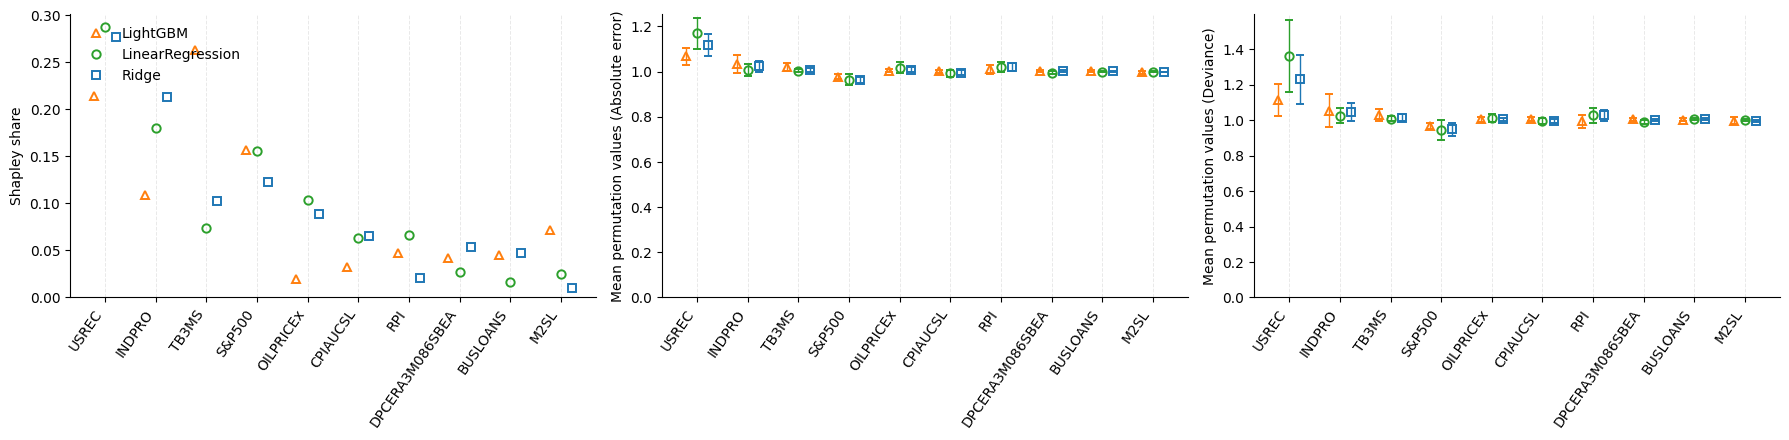

In [114]:
# ============================================================
# Figure "Shapley / Permutation importance" — version finale complète
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Optional

# ============================================================
# ⚙️ UTILITAIRES
# ============================================================

def _normalize_shap(shap_obj: pd.DataFrame | pd.Series) -> pd.Series:
    """Normalise une importance SHAP (somme = 1)."""
    if isinstance(shap_obj, pd.Series):
        s = shap_obj.astype(float)
        tot = s.sum()
        return s / tot if tot > 0 else s
    if isinstance(shap_obj, pd.DataFrame):
        df = shap_obj.copy()
        if "feature" in df.columns and df.index.name != "feature":
            df = df.set_index("feature")
        for col in ["share", "value", "abs_mean", "mean_abs_shap", "importance", "shap"]:
            if col in df.columns:
                s = df[col].astype(float)
                tot = s.sum()
                return s / tot if tot > 0 else s
        raise ValueError("Le DataFrame SHAP doit contenir une colonne valide.")
    raise TypeError("shap_obj doit être une pandas Series ou DataFrame.")

def _prep_perm_df(imp_df: pd.DataFrame) -> pd.DataFrame:
    """Formate la permutation importance pour uniformité."""
    need = {"variable", "perm_score_ratio_mean"}
    if not need.issubset(imp_df.columns):
        raise ValueError("imp_df doit contenir 'variable' et 'perm_score_ratio_mean'.")
    out = imp_df[["variable", "perm_score_ratio_mean"]].copy()
    out = out.rename(columns={"perm_score_ratio_mean": "mean"})
    out["std"] = imp_df["perm_score_ratio_std"].values if "perm_score_ratio_std" in imp_df.columns else np.nan
    return out.set_index("variable")

def _unify_feature_axis(shapleys, perm_abs, perm_dev, top_k):
    """Crée un ordre commun de features, basé sur la moyenne SHAP prioritaire."""
    features = set()
    if shapleys:
        for df in shapleys.values():
            features.update(_normalize_shap(df).index.tolist())
    if perm_abs:
        for df in perm_abs.values():
            features.update(_prep_perm_df(df).index.tolist())
    if perm_dev:
        for df in perm_dev.values():
            features.update(_prep_perm_df(df).index.tolist())
    if not features:
        return []

    score = pd.Series(0.0, index=sorted(features))
    n = pd.Series(0, index=score.index)

    if shapleys:
        for df in shapleys.values():
            s = _normalize_shap(df).reindex(score.index).fillna(0.0)
            score += s
            n += (s > 0).astype(int)
    if (n == 0).all() and perm_abs:
        for df in perm_abs.values():
            p = _prep_perm_df(df).reindex(score.index)
            s = p["mean"].fillna(0.0)
            score += s
            n += (s > 0).astype(int)
    n = n.replace(0, 1)
    order = (score / n).sort_values(ascending=False).index.tolist()
    if top_k:
        order = order[:top_k]
    return order

def _model_styles():
    """Couleurs + marqueurs pour chaque modèle."""
    return {
        "LinearRegression": dict(color="#2ca02c", marker="o"),  # vert
        "Ridge": dict(color="#1f77b4", marker="s"),             # bleu
        "LightGBM": dict(color="#ff7f0e", marker="^"),          # orange
    }

def _jitter_offsets(models: list[str], width: float = 0.22) -> dict[str, float]:
    """Décalage horizontal léger entre modèles pour éviter le chevauchement."""
    if len(models) <= 1:
        return {models[0]: 0.0} if models else {}
    offs = np.linspace(-width, width, len(models))
    return {m: float(o) for m, o in zip(models, offs)}

# ============================================================
# 🎨 TRACÉ DE LA FIGURE
# ============================================================

def plot_importance_panels(
    *,
    shapleys: Optional[Dict[str, pd.DataFrame | pd.Series]] = None,
    perm_abs: Optional[Dict[str, pd.DataFrame]] = None,
    perm_dev: Optional[Dict[str, pd.DataFrame]] = None,
    top_k: Optional[int] = None,
    figsize=(18, 4.2),
    rotate=55,
    ylabels=("Shapley share", "Mean permutation values (Absolute error)", "Mean permutation values (Deviance)"),
    jitter_width=0.22
):
    order = _unify_feature_axis(shapleys, perm_abs, perm_dev, top_k)
    if not order:
        raise ValueError("Aucune feature à afficher.")

    panels = []
    if shapleys is not None: panels.append("shap")
    if perm_abs is not None: panels.append("perm_abs")
    if perm_dev is not None: panels.append("perm_dev")

    fig, axes = plt.subplots(1, len(panels), figsize=figsize, sharex=True)
    if len(panels) == 1:
        axes = [axes]

    model_names = []
    if shapleys: model_names += list(shapleys.keys())
    if perm_abs: model_names += list(perm_abs.keys())
    if perm_dev: model_names += list(perm_dev.keys())
    model_names = sorted(list(set(model_names)))

    styles = _model_styles()
    x = np.arange(len(order))
    offsets = _jitter_offsets(model_names, width=jitter_width)

    for ax, pane in zip(axes, panels):
        for xi in x:
            ax.axvline(xi, color="lightgray", lw=0.7, ls="--", alpha=0.5)

        for m in model_names:
            st = styles.get(m, dict(color="k", marker="o"))
            xv = x + offsets.get(m, 0.0)

            if pane == "shap" and shapleys and m in shapleys:
                s = _normalize_shap(shapleys[m]).reindex(order).fillna(0.0).values
                ax.plot(xv, s, linestyle="none", marker=st["marker"], markersize=6,
                        markerfacecolor="none", markeredgewidth=1.4, color=st["color"], label=m)

            elif pane == "perm_abs" and perm_abs and m in perm_abs:
                p = _prep_perm_df(perm_abs[m]).reindex(order)
                ax.errorbar(xv, p["mean"].values, yerr=p["std"].values, fmt=st["marker"],
                            ms=6, mfc="none", mew=1.4, ecolor=st["color"], elinewidth=1.0,
                            capsize=3, linestyle="none", color=st["color"], label=m)

            elif pane == "perm_dev" and perm_dev and m in perm_dev:
                p = _prep_perm_df(perm_dev[m]).reindex(order)
                ax.errorbar(xv, p["mean"].values, yerr=p["std"].values, fmt=st["marker"],
                            ms=6, mfc="none", mew=1.4, ecolor=st["color"], elinewidth=1.0,
                            capsize=3, linestyle="none", color=st["color"], label=m)

        ax.set_ylabel(
            ylabels[0] if pane == "shap"
            else (ylabels[1] if pane == "perm_abs" else ylabels[2])
        )
        ax.set_xticks(x)
        ax.set_xticklabels(order, rotation=rotate, ha="right")
        ax.set_ylim(bottom=0)
        ax.grid(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    handles = [
        plt.Line2D([], [], marker=styles[m]["marker"], linestyle="none",
                   color=styles[m]["color"], label=m, markerfacecolor="none",
                   markeredgewidth=1.4)
        for m in model_names
    ]
    axes[0].legend(handles=handles, loc="upper left", frameon=False)
    plt.tight_layout()
    return fig

# ============================================================
# 🧱 CONSTRUCTION DES ENTRÉES
# ============================================================

def _get(name): 
    return globals()[name] if name in globals() else None

def _first_not_none(*objs):
    for o in objs:
        if o is not None:
            return o
    return None

def _shap_series_from_df(df):
    if df is None:
        return None
    if isinstance(df, pd.Series):
        return df
    if isinstance(df, pd.DataFrame):
        if "feature" in df.columns and "share" in df.columns:
            return df.set_index("feature")["share"]
        if "share" in df.columns:
            return df["share"]
    return None

# ============================================================
# 🔹 1) SHAP
# ============================================================
shapleys: Dict[str, pd.Series] = {}
_lin   = _shap_series_from_df(_first_not_none(_get("shap_df_lin"), _get("shap_df")))
_ridge = _shap_series_from_df(_first_not_none(_get("shap_df_ridge"), _get("shap_ridge_df")))
_lgbm  = _shap_series_from_df(_first_not_none(_get("shap_df_lgbm"), _get("shap_lgbm_df")))

if _lin is not None:   shapleys["LinearRegression"] = _lin
if _ridge is not None: shapleys["Ridge"] = _ridge
if _lgbm is not None:  shapleys["LightGBM"] = _lgbm

# ============================================================
# 🔹 2) Permutation (MAE) — PATCH robust avec results_perm
# ============================================================
def _coerce_model_name(k: str) -> str:
    k = str(k)
    if k.lower().startswith("linear"): return "LinearRegression"
    if k.lower().startswith("ridge"):  return "Ridge"
    if "lgb" in k.lower() or "light" in k.lower(): return "LightGBM"
    return k

perm_abs: Dict[str, pd.DataFrame] = {}

# 1) Prendre les variables unitaires si elles existent
for var_name, std_key in [
    ("imp_lin",   "LinearRegression"),
    ("imp_ridge", "Ridge"),
    ("imp_lgbm",  "LightGBM"),
]:
    _df = globals().get(var_name, None)
    if isinstance(_df, pd.DataFrame):
        perm_abs[std_key] = _df

# 2) Sinon, tomber sur results_perm (sortie de ta boucle MAE)
rp = globals().get("results_perm", None)
if isinstance(rp, dict):
    for k, v in rp.items():
        if isinstance(v, pd.DataFrame):
            std_key = _coerce_model_name(k)
            if std_key not in perm_abs:
                perm_abs[std_key] = v

# 3) Petit log
print("🔎 perm_abs (MAE) contient :", list(perm_abs.keys()))
missing = {"LinearRegression","Ridge","LightGBM"} - set(perm_abs.keys())
if missing:
    print("⚠️ Manque encore :", sorted(missing))

# ============================================================
# 🔹 3) Permutation (Deviance = MSE)
# ============================================================
perm_dev: Dict[str, pd.DataFrame] = {}
_imp_lin_dev   = _get("imp_lin_dev")
_imp_ridge_dev = _get("imp_ridge_dev")
_imp_lgbm_dev  = _get("imp_lgbm_dev")

if isinstance(_imp_lin_dev, pd.DataFrame):   perm_dev["LinearRegression"] = _imp_lin_dev
if isinstance(_imp_ridge_dev, pd.DataFrame): perm_dev["Ridge"] = _imp_ridge_dev
if isinstance(_imp_lgbm_dev, pd.DataFrame):  perm_dev["LightGBM"] = _imp_lgbm_dev

# ============================================================
# 🎯 TRACÉ FINAL
# ============================================================
fig = plot_importance_panels(
    shapleys=shapleys or None,
    perm_abs=perm_abs or None,
    perm_dev=perm_dev or None,
    top_k=12,
    figsize=(18, 4.5),
    rotate=55
)
plt.show()

# Sauvegarde optionnelle :
# fig.savefig("importance_panels_alignes.png", dpi=300, bbox_inches="tight")

**Règle d’interprétation**
- SHAP indique la part moyenne de chaque variable dans les prédictions.
- Permutation (MAE / Deviance) mesure la perte de performance quand on brouille une variable.
- Une variable importante combine une forte part SHAP et une hausse nette du MAE/Deviance après permutation.

**Interprétation**
- La régression linéaire explique le chômage essentiellement par le cycle économique :
    - USREC (récession) explique à hauteur de 30% à elle seule le chômage — sa permutation accroît l’erreur d’environ 20 %.
    - Les autres variables (finances, prix, monnaie, crédit) ont une influence marginale.

- Ridge apporte aussi pratiquement les mêmes informations.

- LightGBM :
    - la prépondérance du cycle économique dans l'explication du chômage est nunancée à commencer par l'impact de l'indicateur de récression (USREC) qui est descendu à 20% au lieu de plus de 25%. Cet effet est très ressenti dans la production industrielle (INDPRO) où sa contribution a chutté le double. Le modèle capte mieux l'effet de la sphère monétaire notamment la contribution de la création monétaire via l'offre M2. 

**Conclusion :** 
Le chômage reste surtout lié au cycle économique, mais LightGBM montre que les effets monétaires (notamment M2) gagnent en importance. Ce qui révèle une dynamique plus complexe que celle du seul cycle.

# Test de validation des variables importantes

# 🧩 Règles d’interprétation — *Shapley Regression*

La *Shapley regression* repose sur la relation suivante :

$$
y_t = \beta_0^S + \sum_{k=1}^K \beta_k^S \, \phi_{k,t} + \varepsilon_t
$$

où :  
- $y_t$ : variable cible (par ex. le taux de chômage à horizon $h$) ;  
- $\phi_{k,t}$ : valeur SHAP de la variable $k$ à la période $t$ ;  
- $\beta_k^S$ : coefficient d’alignement *Shapley* ;  
- $\Gamma_k^S$ : part moyenne absolue (*Shapley share*) ;  
- $p\text{-value}$ : significativité statistique de $\beta_k^S$.

---

## 🔹 1️⃣ Coefficient d’alignement — $\beta_k^S$

Le coefficient $\beta_k^S$ mesure **dans quelle mesure la composante SHAP** d’une variable est alignée avec la cible réelle $y$.  
Il évalue si le modèle **apprend correctement l’effet de la variable**.

| Valeur de $\beta_k^S$ | Interprétation |
|:-----------------------|:----------------|
| **$\beta_k^S = 1$** | Le modèle estime **exactement** l’effet réel de la variable (*apprentissage parfait*). |
| **$\beta_k^S > 1$** | Le modèle **sous-estime** l’effet réel → la variable a un impact plus fort dans les données que dans le modèle. |
| **$\beta_k^S < 1$** | Le modèle **surestime** l’effet → l’influence de la variable est exagérée. |
| **$\beta_k^S < 0$** | Le modèle attribue à la variable un **effet de signe inverse** à celui observé empiriquement. |

---

## 🔹 2️⃣ Significativité statistique — *p-value*

La p-value teste l’hypothèse nulle $H_0: \beta_k^S = 0$.  
Elle indique si la composante SHAP de la variable $k$ est **statistiquement alignée** avec la cible.

| p-value | Interprétation |
|:---------|:----------------|
| **< 0.01** | Effet **hautement significatif** (***). |
| **< 0.05** | Effet **significatif** (**). |
| **< 0.10** | Effet **marginalement significatif** (*). |
| **≥ 0.10** | Effet **non significatif**. |

---

## 🔹 3️⃣ Importance relative — $\Gamma_k^S$

$$
\Gamma_k^S = \frac{\overline{|\phi_k|}}{\sum_j \overline{|\phi_j|}}
$$

La part moyenne absolue (*Shapley share*) mesure **l’importance relative** d’une variable dans la décomposition SHAP.  
Elle indique **dans quelle proportion** la variable contribue à la prédiction du modèle.

| Valeur de $\Gamma_k^S$ | Interprétation |
|:------------------------|:----------------|
| **élevée (≥ 0.15)** | Variable **majeure** : le modèle s’appuie fortement dessus. |
| **moyenne (≈ 0.05–0.15)** | Variable **complémentaire** : contribue modérément. |
| **faible (< 0.05)** | Variable **secondaire** ou redondante. |

---

## 🔹 4️⃣ Corrélation — $\rho(\phi_k, y)$

La corrélation entre la composante SHAP et la cible indique **le signe et la direction de la relation** :

| Valeur de $\rho(\phi_k, y)$ | Interprétation |
|:-----------------------------|:----------------|
| **$\rho > 0$** | La variable a un **effet positif** sur la cible (sa hausse augmente $y$). |
| **$\rho < 0$** | La variable a un **effet négatif** sur la cible (sa hausse réduit $y$). |
| **$|\rho| \approx 0$** | Effet **instable** ou **non directionnel**. |

---

## 🧭 Résumé visuel

| Élément | Notation | Interprétation principale |
|:----------|:-----------:|:--------------------------|
| **Coefficient Shapley** | $\beta_k^S$ | Alignement entre la contribution SHAP et la cible $y$. |
| **p-value** | — | Test de significativité de $\beta_k^S$. |
| **Part Shapley** | $\Gamma_k^S$ | Importance relative moyenne de la variable. |
| **Corrélation** | $\rho(\phi_k, y)$ | Signe et direction de l’effet de la variable sur la cible. |

In [45]:
# ==========================================================
# STEP 3 — Shapley regressions (Linear, Ridge, LightGBM)
# ==========================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm
import shap
from typing import Optional, Tuple, List

print(f"[INFO] Version SHAP détectée : {shap.__version__}")

# ==========================================================
# 🔧 UTILITAIRES
# ==========================================================
def _sigstars(p: float) -> str:
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.1 else ""))

def _shap_shares(phi: np.ndarray, feat_names: list[str]) -> pd.Series:
    abs_mean = np.mean(np.abs(phi), axis=0)
    tot = abs_mean.sum()
    shares = abs_mean / tot if tot > 0 else abs_mean
    return pd.Series(shares, index=feat_names).sort_values(ascending=False)

def _apply_preproc_general(X: pd.DataFrame, prep: Optional[dict]) -> pd.DataFrame:
    """Version sûre au cas où apply_preproc n'est pas dispo."""
    if prep is None:
        return X
    Xp = X.copy()
    lower = prep.get("lower_wins", prep.get("lower", None))
    upper = prep.get("upper_wins", prep.get("upper", None))
    if lower is not None and upper is not None:
        lower_s = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
        upper_s = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
        Xp = Xp.clip(lower=lower_s, upper=upper_s, axis=1)
    if prep.get("norm", False):
        mean = prep.get("mean", None)
        std  = prep.get("std",  None)
        if mean is not None and std is not None:
            mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
            std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
            Xp = (Xp - mean_s) / std_s.replace(0, 1)
    return Xp

def _get_preproc_apply_fn():
    return globals().get("apply_preproc", _apply_preproc_general)

# ==========================================================
# ⚙️ SHAP Extraction robuste (compat toutes versions)
# ==========================================================
def shap_components_oos_for_last_window(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    restrict_eval_window: Optional[Tuple[str, str]] = None,
) -> Tuple[np.ndarray, np.ndarray, list[str], float, str]:
    """
    Récupère les valeurs SHAP pour la dernière fenêtre du modèle (Linear, Ridge, LightGBM),
    compatible avec anciennes et nouvelles versions de SHAP.
    """
    if not isinstance(df_all.index, pd.DatetimeIndex):
        df_all.index = pd.to_datetime(df_all.index)

    X_full, Y_full, model_final, prep_final, end_time_final = _get_last_model_and_data(
        exp_results, df_all, target_col
    )
    feat_names = list(X_full.columns)
    df_win = df_all.loc[:end_time_final].copy()

    X_raw, y = _build_X_y_for_window(df_win, feat_names, target_col, h=h)
    if X_raw is None or len(X_raw) == 0:
        raise RuntimeError("Fenêtre trop courte pour construire X_t et y_{t+h}.")

    eval_start, eval_end = _eval_window_bounds(restrict_eval_window)
    mask_window = _mask_eval_window(df_win, len(y), h, eval_start, eval_end)
    valid = _mask_valid_rows(X_raw, y, mask_window)
    if not np.any(valid):
        raise RuntimeError("Aucune observation valide après masquage.")

    X_raw = X_raw.loc[valid]
    y_use = y.loc[valid]
    X_pp = _get_preproc_apply_fn()(X_raw, prep_final)

    model_name = getattr(model_final, "__class__", type("M", (), {})).__name__.lower()
    base_values = None
    phi = None

    # --- LightGBM (avec gestion des versions SHAP)
    if "lgbm" in model_name or "lightgbm" in model_name:
        try:
            # versions récentes : paramètre accepté dans __init__
            expl = shap.TreeExplainer(model_final, X_pp, check_additivity=False)
            phi = expl.shap_values(X_pp)
            base_values = getattr(expl, "expected_value", None)
        except TypeError:
            # versions anciennes : paramètre seulement accepté dans shap_values()
            expl = shap.TreeExplainer(model_final, X_pp)
            phi = expl.shap_values(X_pp, check_additivity=False)
            base_values = getattr(expl, "expected_value", None)
        except Exception as e:
            raise RuntimeError(f"TreeExplainer LightGBM a échoué: {e}")

    # --- Linear / Ridge
    else:
        try:
            expl = shap.Explainer(model_final, X_pp)
            shap_vals = expl(X_pp)
            vals = getattr(shap_vals, "values", None)
            phi = np.array(vals if vals is not None else shap_vals)
            base_values = getattr(expl, "expected_value", None)
        except Exception:
            coef = getattr(model_final, "coef_", None)
            intercept = getattr(model_final, "intercept_", 0.0)
            if coef is None:
                raise RuntimeError(f"Impossible de calculer SHAP pour {model_name} (pas de coef_).")
            phi = X_pp.to_numpy() * np.asarray(coef).reshape(1, -1)
            base_values = np.asarray(intercept)

    # --- Post-traitement
    if isinstance(phi, list):
        phi = phi[0]
    if phi.ndim == 3:
        phi = phi[0]
    if phi.shape[1] != X_pp.shape[1]:
        raise ValueError(f"Mismatch dimensions SHAP vs features pour {model_name}.")

    return phi, y_use.to_numpy(), feat_names, base_values, model_name

# ==========================================================
# 📊 Régression de Shapley
# ==========================================================
def shapley_regression(y_true: np.ndarray, phi: np.ndarray, feat_names: list[str], cov_type: str = "HC1") -> pd.DataFrame:
    X = sm.add_constant(phi)
    res = sm.OLS(y_true, X).fit(cov_type=cov_type)
    out = pd.DataFrame({
        "βˢ": res.params[1:],
        "std_err": res.bse[1:],
        "t": res.tvalues[1:],
        "p-value": res.pvalues[1:]
    }, index=feat_names)
    out["sig"] = out["p-value"].map(_sigstars)
    return out

# ==========================================================
# 📜 Table finale type « Table III »
# ==========================================================
def shapley_table_generic(
    *,
    exp_results: dict,
    df_all: pd.DataFrame,
    target_col: str,
    h: int = 12,
    restrict_eval_window: Optional[Tuple[str, str]] = None,
    model_label: str = "Model",
) -> pd.DataFrame:
    phi, y, feat_names, base_values, _auto_name = shap_components_oos_for_last_window(
        exp_results=exp_results,
        df_all=df_all,
        target_col=target_col,
        h=h,
        restrict_eval_window=restrict_eval_window,
    )
    reg = shapley_regression(y, phi, feat_names)
    shares = _shap_shares(phi, feat_names).rename("Γˢ")

    tbl = pd.concat([reg[["βˢ", "p-value", "sig"]], shares], axis=1)
    tbl = tbl.sort_values("Γˢ", ascending=False)
    tbl.columns = pd.MultiIndex.from_product([[model_label], tbl.columns])
    return tbl

# ==========================================================
# 🚀 EXÉCUTION : produit 3 tables (Linear, Ridge, LightGBM)
# ==========================================================
if __name__ == "__main__":
    # Helpers
    def _ensure_exp(exp_obj, bundle_obj):
        if isinstance(exp_obj, dict):
            return exp_obj
        if isinstance(bundle_obj, dict) and "models" in bundle_obj:
            return exp_from_bundle_no_refit(bundle_obj)
        raise RuntimeError("Fournis exp_results ou un bundle valide.")

    exp_lin   = _ensure_exp(globals().get("exp_lin", None),   globals().get("linreg_bundle", None))
    exp_ridge = _ensure_exp(globals().get("exp_ridge", None), globals().get("ridge_bundle", None))
    exp_lgbm  = _ensure_exp(globals().get("exp_lgbm", None),  globals().get("lgbm_bundle", None))

    def _get_h(bundle_like, default=12):
        if isinstance(bundle_like, dict):
            return int(bundle_like.get("params", {}).get("horizon", default))
        return default

    h_lin   = _get_h(globals().get("linreg_bundle"), 12)
    h_ridge = _get_h(globals().get("ridge_bundle"), 12)
    h_lgbm  = _get_h(globals().get("lgbm_bundle"), 12)

    eval_window = ("1990-01-01", "2025-12-31")
    target = "UNRATE"

    # --- Exécution des trois modèles
    tbl_lin = shapley_table_generic(exp_results=exp_lin, df_all=df_stationary_test, target_col=target, h=h_lin,
                                   restrict_eval_window=eval_window, model_label="Linear regression")
    tbl_ridge = shapley_table_generic(exp_results=exp_ridge, df_all=df_stationary_test, target_col=target, h=h_ridge,
                                     restrict_eval_window=eval_window, model_label="Ridge regression")
    tbl_lgbm = shapley_table_generic(exp_results=exp_lgbm, df_all=df_stationary_test, target_col=target, h=h_lgbm,
                                    restrict_eval_window=eval_window, model_label="LightGBM")

    # --- Affichage & sauvegarde
    tbl_all = pd.concat([tbl_lin, tbl_ridge, tbl_lgbm], axis=1)
    print("\n=== Shapley regression — 3 modèles ===")
    with pd.option_context("display.max_rows", None, "display.width", 200):
        print(tbl_all.round(3))

    tbl_lin.round(4).to_csv("table_shapley_regression_linear.csv", encoding="utf-8")
    tbl_ridge.round(4).to_csv("table_shapley_regression_ridge.csv", encoding="utf-8")
    tbl_lgbm.round(4).to_csv("table_shapley_regression_lgbm.csv", encoding="utf-8")
    tbl_all.round(4).to_csv("table_shapley_regression_all.csv", encoding="utf-8")

    print("\n💾 Sauvé :")
    print(" - table_shapley_regression_linear.csv")
    print(" - table_shapley_regression_ridge.csv")
    print(" - table_shapley_regression_lgbm.csv")
    print(" - table_shapley_regression_all.csv")

[INFO] Version SHAP détectée : 0.48.0

=== Shapley regression — 3 modèles ===
                Linear regression                     Ridge regression                     LightGBM                    
                               βˢ p-value  sig     Γˢ               βˢ p-value  sig     Γˢ       βˢ p-value  sig     Γˢ
USREC                       0.907   0.047   **  0.269            1.442   0.047   **  0.259    3.556   0.000  ***  0.214
INDPRO                      0.254   0.744       0.186            0.330   0.744       0.220    1.625   0.080    *  0.089
S&P500                     -0.827   0.045   **  0.153           -1.615   0.045   **  0.120   -0.223   0.772       0.147
OILPRICEx                   0.083   0.922       0.109            0.149   0.922       0.093   -7.295   0.006  ***  0.022
TB3MS                       0.635   0.541       0.074            0.702   0.541       0.103    1.381   0.014   **  0.288
RPI                        -0.081   0.955       0.070           -0.392   0.955    

🧩 Règle d’interprétation
- β^S ≈ 1 → effet bien capté par le modèle.
- β^S > 1 → effet sous-estimé (le modèle apprend trop faiblement cette variable).
- β^S < 1 → effet surestimé (le modèle amplifie trop la variable).
- Γ^S (corrélation SHAP–cible) : indique la direction de l’impact sur le chômage.
- p-value et étoiles (***, **, *) : significativité statistique des coefficients.

Régression linéaire et Ridge : 
- BUSLOANS domine nettement (β^S = 18.4, p < 0.01) → effet sous-estimé et fortement lié au chômage.
- USREC est aussi significatif et positivement corrélés au chômage.
- S&P 500 montre un effet négatif significatif (hausse du marché = baisse du chômage).
- Les autres variables (TB3MS, INDPRO, M2SL, CPI) sont faiblement ou non significatives.

LightGBM : 
- le modèle ne minimise pas le rôle des cycles économiques, au contraire, il a ajouté la variable INDPRO comme significative. 
- M2SL (liquidité monétaire) et OILPRICEx apparaissent plus influents, suggérant une composante monétaire et énergétique dans la dynamique du chômage.
- Mais l'effet de OILPRICEx est surestimé par le modèle tout comme le revenu, bien qu'elles sont significatives.

# Explorer les relations fonctionnelles

In [46]:
# ============================================================
# 🧩 Utilitaires communs
# ============================================================

def _get_model_from_bundle(bundle: dict):
    """Retourne le modèle final, le préprocesseur et les features à partir d’un bundle."""
    if bundle is None:
        raise ValueError("Bundle manquant.")

    # 1️⃣ modèle final (dernier de la liste)
    models = bundle.get("models", None)
    if isinstance(models, (list, tuple)) and len(models) > 0:
        model_final = models[-1]
    else:
        model_final = bundle.get("model") or bundle.get("final_model")
        if model_final is None:
            raise KeyError("Impossible de trouver le modèle dans le bundle.")

    # 2️⃣ préprocesseur
    preprocs = bundle.get("preprocs", None)
    prep_final = preprocs[-1] if isinstance(preprocs, (list, tuple)) and len(preprocs) > 0 else None

    # 3️⃣ features utilisées
    features = (bundle.get("params", {}) or {}).get("features", None)
    if not features:
        features = list(getattr(model_final, "feature_names_in_", []))
    if not features:
        raise KeyError("Noms de variables introuvables (params['features'] manquants).")

    # 4️⃣ période finale d’entraînement
    if "train_fit_dates" in bundle and len(bundle["train_fit_dates"]) > 0:
        end_time_final = pd.to_datetime(bundle["train_fit_dates"][-1])
    else:
        end_time_final = df_stationary_test.index.max()

    # 5️⃣ jeu de données à utiliser
    X_full = df_stationary_test.loc[:end_time_final, features].copy()
    X_full = X_full.dropna(how="any")

    return model_final, prep_final, X_full, features


In [47]:
# ============================================================
# 📊 Fonction de tracé SHAP fonctionnel
# ============================================================

def plot_functional_forms_selected(
    *,
    model_any,
    X_full: pd.DataFrame,
    selected_vars: list[str],
    prep=None,
    model_name: str = "",
    figsize=(5.2, 6.5),
    color_points="tab:gray",
    color_line="black",
    scatter_alpha=0.55,
    s=16,
    line_deg=3,
):
    """
    Calcule les valeurs SHAP du modèle sur X_full et trace les courbes
    fonctionnelles (valeur observée vs contribution SHAP) pour `selected_vars`.
    """
    feature_names = list(X_full.columns)

    # --- helpers internes
    def _to_df(X_like):
        if isinstance(X_like, pd.DataFrame):
            return X_like
        return pd.DataFrame(np.asarray(X_like), columns=feature_names)

    def _apply_prep(X_df):
        if prep is None:
            return X_df
        if hasattr(prep, "transform"):
            return prep.transform(X_df)
        return X_df

    # --- fonction de prédiction
    if hasattr(model_any, "predict"):
        predict_fn = lambda X_like: np.asarray(model_any.predict(_apply_prep(_to_df(X_like)))).ravel()
    else:
        raise TypeError("Modèle non compatible (pas de méthode predict).")

    # --- calcul SHAP
    try:
        expl = shap.Explainer(predict_fn, X_full)
        shap_vals = expl(X_full)
        phi = getattr(shap_vals, "values", None)
        if phi is None and isinstance(shap_vals, np.ndarray):
            phi = shap_vals
    except Exception:
        # fallback linéaire si SHAP échoue
        coef = getattr(model_any, "coef_", None)
        if coef is not None:
            phi = X_full.to_numpy() * np.asarray(coef).reshape(1, -1)
        else:
            raise RuntimeError(f"Impossible de calculer SHAP pour {model_name}.")

    phi = np.asarray(phi)
    if phi.ndim == 3:
        phi = phi[0]

    # --- tracé pour chaque variable sélectionnée
    n = len(selected_vars)
    fig, axes = plt.subplots(n, 1, figsize=figsize, sharey=False)
    if n == 1:
        axes = [axes]

    for r, feat in enumerate(selected_vars):
        if feat not in feature_names:
            continue
        j = feature_names.index(feat)
        x = X_full[feat].to_numpy()
        yv = phi[:, j]
        mask = ~(np.isnan(x) | np.isnan(yv))
        x, yv = x[mask], yv[mask]

        ax = axes[r]
        ax.scatter(x, yv, alpha=scatter_alpha, s=s, edgecolors="none", c=color_points)

        # --- courbe polynomiale
        if len(x) > line_deg + 1:
            try:
                coefs = np.polyfit(x, yv, deg=line_deg)
                x_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
                y_line = np.polyval(coefs, x_line)
                ax.plot(x_line, y_line, color=color_line, linewidth=1.6)
            except Exception:
                pass

        ax.axhline(0, color="grey", linewidth=0.8, alpha=0.7)
        ax.axvline(0, color="grey", linewidth=0.8, alpha=0.7)
        ax.set_ylabel("Shapley value")
        ax.set_title(feat, fontsize=10)
        if r == n - 1:
            ax.set_xlabel("Observed values")
        else:
            ax.set_xlabel("")
        ax.grid(axis="y", linestyle=":", alpha=0.35)

    fig.suptitle(f"Functional Forms — {model_name}", fontsize=12, y=1.02)
    plt.tight_layout()
    return fig, axes

## Pour les modèles linéaires uniquement

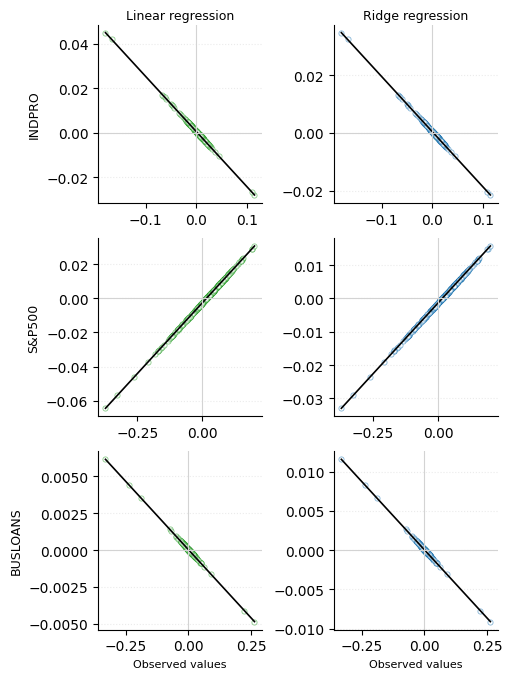

In [ ]:
# ============================================================
# Functional-form plots — GRID (rows=variables, cols=models)
# Models: LinearRegression, Ridge
# (LightGBM et TreeExplainer retirés)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# ---------------------- Helpers: préproc "safe"
def _apply_prep(X: pd.DataFrame, prep):
    if prep is None:
        return X
    if hasattr(prep, "transform"):
        try:
            return pd.DataFrame(prep.transform(X), index=X.index, columns=X.columns)
        except Exception:
            # cas dict winsor/normalisation custom
            lower = getattr(prep, "get", lambda k, d=None: None)("lower_wins")
            if lower is None and hasattr(prep, "get"):
                lower = prep.get("lower", None)
            upper = getattr(prep, "get", lambda k, d=None: None)("upper_wins")
            if upper is None and hasattr(prep, "get"):
                upper = prep.get("upper", None)
            Xp = X.copy()
            if lower is not None and upper is not None:
                lo = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
                up = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
                Xp = Xp.clip(lower=lo, upper=up, axis=1)
            if hasattr(prep, "get") and prep.get("norm", False):
                mean = prep.get("mean", None)
                std  = prep.get("std",  None)
                if mean is not None and std is not None:
                    mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
                    std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
                    Xp = (Xp - mean_s) / std_s.replace(0, 1)
            return Xp
    return X

# ---------------------- Helpers: extraction bundle -> (model, prep, X_full, features)
def _get_model_from_bundle(bundle: dict, df_all: pd.DataFrame):
    if bundle is None or not isinstance(bundle, dict):
        raise ValueError("Bundle manquant ou invalide.")

    # modèle final (dernier de la liste)
    if isinstance(bundle.get("models"), (list, tuple)) and len(bundle["models"]) > 0:
        model_final = bundle["models"][-1]
    else:
        model_final = bundle.get("model") or bundle.get("final_model")
        if model_final is None:
            raise KeyError("Impossible de trouver le modèle dans le bundle.")

    # préproc final (optionnel)
    preprocs = bundle.get("preprocs", None)
    prep_final = preprocs[-1] if isinstance(preprocs, (list, tuple)) and len(preprocs) > 0 else None

    # features utilisées au fit
    features = (bundle.get("params", {}) or {}).get("features", None)
    if not features:
        features = list(getattr(model_final, "feature_names_in_", []))
    if not features:
        raise KeyError("params['features'] absent et model.feature_names_in_ indisponible.")

    # borne de fin (dernière fenêtre d'apprentissage), sinon tout
    if "train_fit_dates" in bundle and len(bundle["train_fit_dates"]) > 0:
        end_time_final = pd.to_datetime(bundle["train_fit_dates"][-1])
    else:
        end_time_final = df_all.index.max()

    X_full = df_all.loc[:end_time_final, features].copy()
    X_full = X_full.dropna(how="any")
    return model_final, prep_final, X_full, list(X_full.columns)

# ---------------------- SHAP robuste (Explainer générique -> fallback linéaire)
def _compute_phi(model, X: pd.DataFrame, prep=None):
    """
    Renvoie une matrice phi (n_obs, n_features) de contributions.
    - Explainer générique shap.Explainer(predict_fn, X).
    - Fallback linéaire exact si coef_ disponible.
    """
    feat_names = list(X.columns)

    def _to_df(X_like):
        if isinstance(X_like, pd.DataFrame):
            return X_like
        return pd.DataFrame(np.asarray(X_like), columns=feat_names)

    def predict_fn(X_like):
        X_df = _to_df(X_like)
        Xp = _apply_prep(X_df, prep)
        yhat = model.predict(Xp)
        return np.asarray(yhat).ravel()

    # Essai explainer "agnostique"
    try:
        expl = shap.Explainer(predict_fn, X)    # background = X
        sv = expl(X)                            # explique X
        vals = getattr(sv, "values", None)
        phi = np.array(vals if vals is not None else sv)
    except Exception:
        # Fallback linéaire exact si possible
        coef = getattr(model, "coef_", None)
        if coef is None:
            raise RuntimeError("SHAP explainer et fallback linéaire indisponibles pour ce modèle.")
        Xp = _apply_prep(X, prep)
        phi = Xp.to_numpy() * np.asarray(coef).reshape(1, -1)

    if phi.ndim == 3:  # multi-output
        phi = phi[0]
    if phi.shape[1] != X.shape[1]:
        raise ValueError("phi/dimensions incohérentes avec X.")
    return phi

# ---------------------- Tracé en grille (rows=variables, cols=models)
def plot_functional_grid(models_dict, X_dict, selected_vars, poly_deg=3,
                         scatter_alpha=0.55, s=14,
                         colors=("tab:green","tab:blue"),
                         figsize_per_cell=(2.4, 2.2), sharey=True):
    """
    models_dict: {model_name: (model, prep)}
    X_dict:      {model_name: DataFrame (toutes features du fit)}
    selected_vars: ordre des lignes
    """
    model_names = list(models_dict.keys())

    # --- Unifier X sur l'intersection des index pour éviter les trous
    common_index = None
    for m in model_names:
        idx = X_dict[m].index
        common_index = idx if common_index is None else common_index.intersection(idx)

    # Vérifier la présence des features demandées
    for v in selected_vars:
        for m in model_names:
            if v not in X_dict[m].columns:
                raise KeyError(f"'{v}' manquant dans les features du modèle {m}.")

    # Hauteur/largeur de la figure
    n_rows = len(selected_vars)
    n_cols = len(model_names)
    fig_w = n_cols * figsize_per_cell[0]
    fig_h = n_rows * figsize_per_cell[1]
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), sharey=sharey)

    if n_rows == 1: axes = np.array([axes])
    if n_cols == 1: axes = axes.reshape(-1, 1)

    # --- boucle colonnes (modèles)
    for c, (mname, (model, prep)) in enumerate(models_dict.items()):
        X_full = X_dict[mname].loc[common_index]  # alignement temporel
        phi = _compute_phi(model, X_full, prep=prep)

        color_pts = colors[c % len(colors)]
        for r, feat in enumerate(selected_vars):
            ax = axes[r, c]
            j = X_full.columns.get_loc(feat)
            x = X_full.iloc[:, j].to_numpy()
            y = phi[:, j]
            mask = ~(np.isnan(x) | np.isnan(y))
            x, y = x[mask], y[mask]

            # points en BLANC + contour coloré
            ax.scatter(x, y, alpha=scatter_alpha, s=s,
                       facecolors="white", edgecolors=color_pts, linewidths=0.6)

            # petite courbe polynomiale lissée
            if len(x) > poly_deg + 1:
                try:
                    coefs = np.polyfit(x, y, deg=poly_deg)
                    x_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
                    y_line = np.polyval(coefs, x_line)
                    ax.plot(x_line, y_line, color="black", linewidth=1.2)
                except Exception:
                    pass

            ax.axhline(0, color="lightgray", lw=0.8)
            ax.axvline(0, color="lightgray", lw=0.8)
            ax.grid(axis="y", linestyle=":", alpha=0.25)

            # titres/bords minimalistes
            if r == 0:
                ax.set_title(mname, fontsize=9, pad=4)
            else:
                ax.set_title("")
            if c == 0:
                ax.set_ylabel(feat, fontsize=9)
            else:
                ax.set_ylabel("")
            if r == n_rows - 1:
                ax.set_xlabel("Observed values", fontsize=8)
            else:
                ax.set_xlabel("")
            for spine in ("top","right"):
                ax.spines[spine].set_visible(False)

    plt.tight_layout(h_pad=0.8, w_pad=0.8)
    return fig, axes

# ============================ USAGE ============================
# 1) Choisis tes variables (une par ligne)
selected_vars = ["INDPRO", "S&P500", "BUSLOANS"]  # adapte aux noms de ton dataset

# 2) Extraire (model, prep, X_full) pour chaque bundle
assert isinstance(df_stationary_test.index, pd.DatetimeIndex)
df_stationary_test = df_stationary_test.sort_index()

mdl_lin,  prep_lin,  X_lin,  feats_lin  = _get_model_from_bundle(linreg_bundle, df_stationary_test)
mdl_ridge,prep_rdg,  X_rdg,  feats_rdg  = _get_model_from_bundle(ridge_bundle,  df_stationary_test)

# 3) Construire les dicts d’entrée (2 modèles)
models_dict = {
    "Linear regression": (mdl_lin,  prep_lin),
    "Ridge regression":  (mdl_ridge,prep_rdg),
}
X_dict = {
    "Linear regression": X_lin,
    "Ridge regression":  X_rdg,
}

# 4) Tracer la grille
plt.style.use("default")  # fond clair
fig, axes = plot_functional_grid(
    models_dict=models_dict,
    X_dict=X_dict,
    selected_vars=selected_vars,
    poly_deg=3,
    figsize_per_cell=(2.6, 2.3),
    sharey=False
)
plt.show()

# (optionnel) Sauvegarde
# fig.savefig("functional_forms_grid_2models.png", dpi=300, bbox_inches="tight", facecolor="white")

## LGBM uniquement

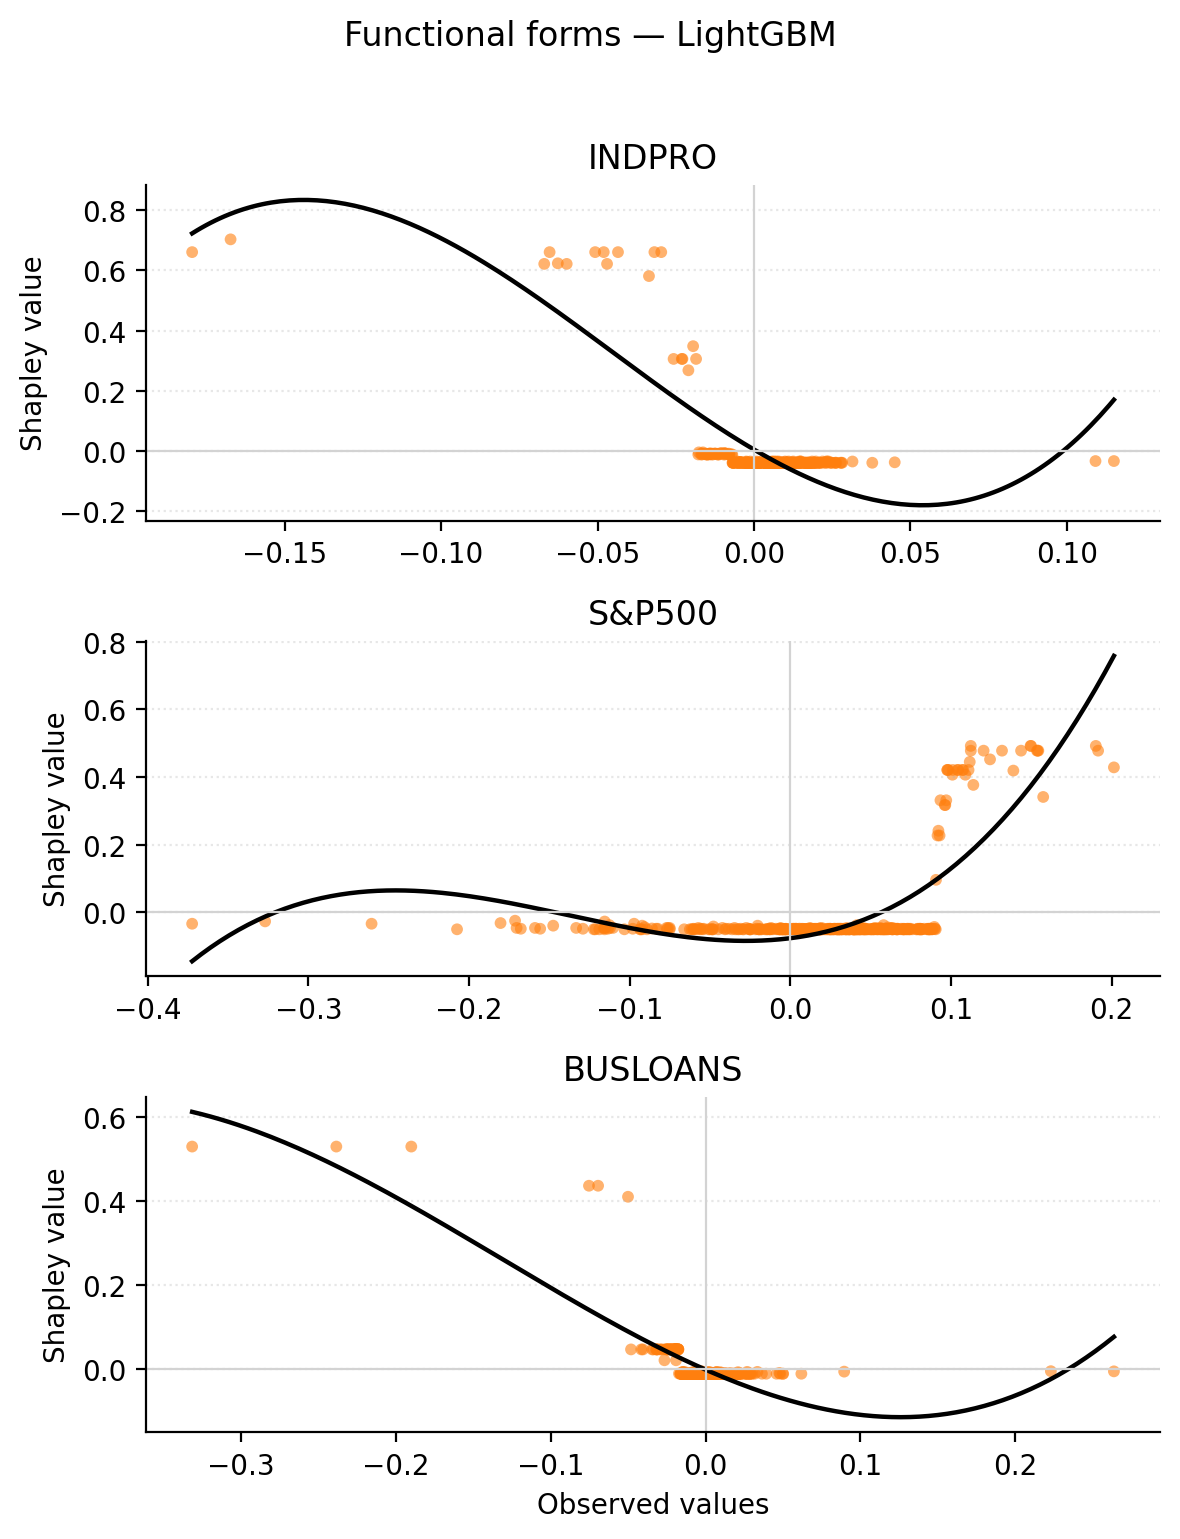

In [93]:
# ============================================================
# Functional-form plots — LightGBM (robuste & autonome, FIX)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor

# ---------------------- préproc "safe"
def _apply_prep(X: pd.DataFrame, prep):
    if prep is None:
        return X
    if hasattr(prep, "transform"):
        Xp = prep.transform(X)
        try:
            return pd.DataFrame(Xp, index=X.index, columns=X.columns)
        except Exception:
            return pd.DataFrame(Xp, index=X.index)
    Xp = X.copy()
    if isinstance(prep, dict):
        lower = prep.get("lower_wins", prep.get("lower", None))
        upper = prep.get("upper_wins", prep.get("upper", None))
        if lower is not None and upper is not None:
            lo = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
            up = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
            Xp = Xp.clip(lower=lo, upper=up, axis=1)
        if prep.get("norm", False):
            mean = prep.get("mean", None)
            std  = prep.get("std",  None)
            if mean is not None and std is not None:
                mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
                std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
                Xp = (Xp - mean_s) / std_s.replace(0, 1)
    return Xp

# ---------------------- extraction depuis le bundle (FIX sur DatetimeIndex)
def get_lgbm_from_bundle(lgbm_bundle: dict, df_all: pd.DataFrame):
    if not isinstance(lgbm_bundle, dict):
        raise ValueError("lgbm_bundle invalide.")
    # modèle final
    model = None
    if isinstance(lgbm_bundle.get("models"), (list, tuple)) and len(lgbm_bundle["models"]) > 0:
        model = lgbm_bundle["models"][-1]
    else:
        model = lgbm_bundle.get("model") or lgbm_bundle.get("final_model")
    if not isinstance(model, LGBMRegressor):
        raise TypeError("Le modèle récupéré n'est pas un LGBMRegressor.")

    # pré-proc final (optionnel)
    prep = None
    preprocs = lgbm_bundle.get("preprocs", None)
    if isinstance(preprocs, (list, tuple)) and len(preprocs) > 0:
        prep = preprocs[-1]

    # features au fit (respecter l'ordre LightGBM)
    features = (lgbm_bundle.get("params", {}) or {}).get("features", None)
    if not features:
        feat_model = getattr(model, "feature_name_", None)
        if not feat_model:
            booster = getattr(model, "_Booster", None)
            if booster is not None and hasattr(booster, "feature_name"):
                feat_model = booster.feature_name()
        features = list(feat_model) if feat_model else None
    if not features:
        raise KeyError("Features introuvables (params['features'] ou feature_name_).")

    # borne de fin: utiliser longueur plutôt que vérité implicite (FIX)
    end_time = df_all.index.max()
    if "train_fit_dates" in lgbm_bundle:
        tfd = lgbm_bundle["train_fit_dates"]
        try:
            n_tfd = len(tfd)
        except Exception:
            n_tfd = 0
        if n_tfd > 0:
            end_time = pd.to_datetime(tfd[-1])

    X_full = df_all.loc[:end_time, features].copy().dropna(how="any")

    # réordonner selon l'ordre du modèle si disponible
    try:
        feat_model = getattr(model, "feature_name_", None)
        if not feat_model:
            booster = getattr(model, "_Booster", None)
            if booster is not None and hasattr(booster, "feature_name"):
                feat_model = booster.feature_name()
        if feat_model:
            X_full = X_full.loc[:, feat_model]
    except Exception:
        pass

    return model, prep, X_full, list(X_full.columns)

# ---------------------- SHAP (TreeExplainer, additivity off)
def compute_lgbm_shap_matrix(model: LGBMRegressor, X_full: pd.DataFrame, prep=None) -> np.ndarray:
    Xp = _apply_prep(X_full, prep).astype(float)
    expl = shap.TreeExplainer(model)  # pour régression
    sv = expl.shap_values(Xp, check_additivity=False)
    phi = sv[0] if isinstance(sv, list) else np.asarray(sv)
    if phi.ndim == 3:
        phi = phi[0]
    if phi.shape[1] != X_full.shape[1]:
        raise ValueError("Dimensions SHAP incohérentes avec X_full. Vérifie l'ordre des colonnes.")
    return phi

# ---------------------- tracé functional-form
def plot_functional_forms_lightgbm(model, X_full, phi, selected_vars,
                                   poly_deg=3, color_points="tab:orange",
                                   color_line="black", scatter_alpha=0.6, s=18,
                                   figsize=(6.8, 7.2)):
    feat_names = list(X_full.columns)
    for v in selected_vars:
        if v not in feat_names:
            raise KeyError(f"Variable '{v}' absente de X_full.")
    n = len(selected_vars)
    fig, axes = plt.subplots(n, 1, figsize=figsize, sharey=False)
    if n == 1: axes = [axes]
    for r, feat in enumerate(selected_vars):
        j = feat_names.index(feat)
        x = X_full.iloc[:, j].to_numpy()
        y = phi[:, j]
        m = ~(np.isnan(x) | np.isnan(y))
        x, y = x[m], y[m]
        ax = axes[r]
        ax.scatter(x, y, c=color_points, alpha=scatter_alpha, s=s, edgecolors="none")
        if len(x) > poly_deg + 1:
            try:
                coefs = np.polyfit(x, y, deg=poly_deg)
                xs = np.linspace(np.nanmin(x), np.nanmax(x), 200)
                ys = np.polyval(coefs, xs)
                ax.plot(xs, ys, color=color_line, lw=1.6)
            except Exception:
                pass
        ax.axhline(0, color="lightgray", lw=0.8)
        ax.axvline(0, color="lightgray", lw=0.8)
        ax.set_ylabel("Shapley value")
        ax.set_title(feat)
        if r == n - 1:
            ax.set_xlabel("Observed values")
        else:
            ax.set_xlabel("")
        ax.grid(axis="y", linestyle=":", alpha=0.3)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    fig.suptitle("Functional forms — LightGBM", y=1.02)
    plt.tight_layout()
    return fig, axes

# ============================ USAGE ============================
# 1) Récupérer modèle / préproc / X_full
mdl_lgbm, prep_lgbm, X_lgbm, feat_lgbm = get_lgbm_from_bundle(lgbm_bundle, df_stationary_test)

# 2) Calculer SHAP
phi_lgbm = compute_lgbm_shap_matrix(mdl_lgbm, X_lgbm, prep=prep_lgbm)

# 3) Variables à illustrer
selected_vars = ["INDPRO", "S&P500", "BUSLOANS"]  # adapte à ton dataset

# 4) Tracer
fig, axes = plot_functional_forms_lightgbm(
    model=mdl_lgbm, X_full=X_lgbm, phi=phi_lgbm,
    selected_vars=selected_vars, poly_deg=3,
    color_points="tab:orange", color_line="black", figsize=(6.0, 7.5)
)
plt.show()

### Akambana

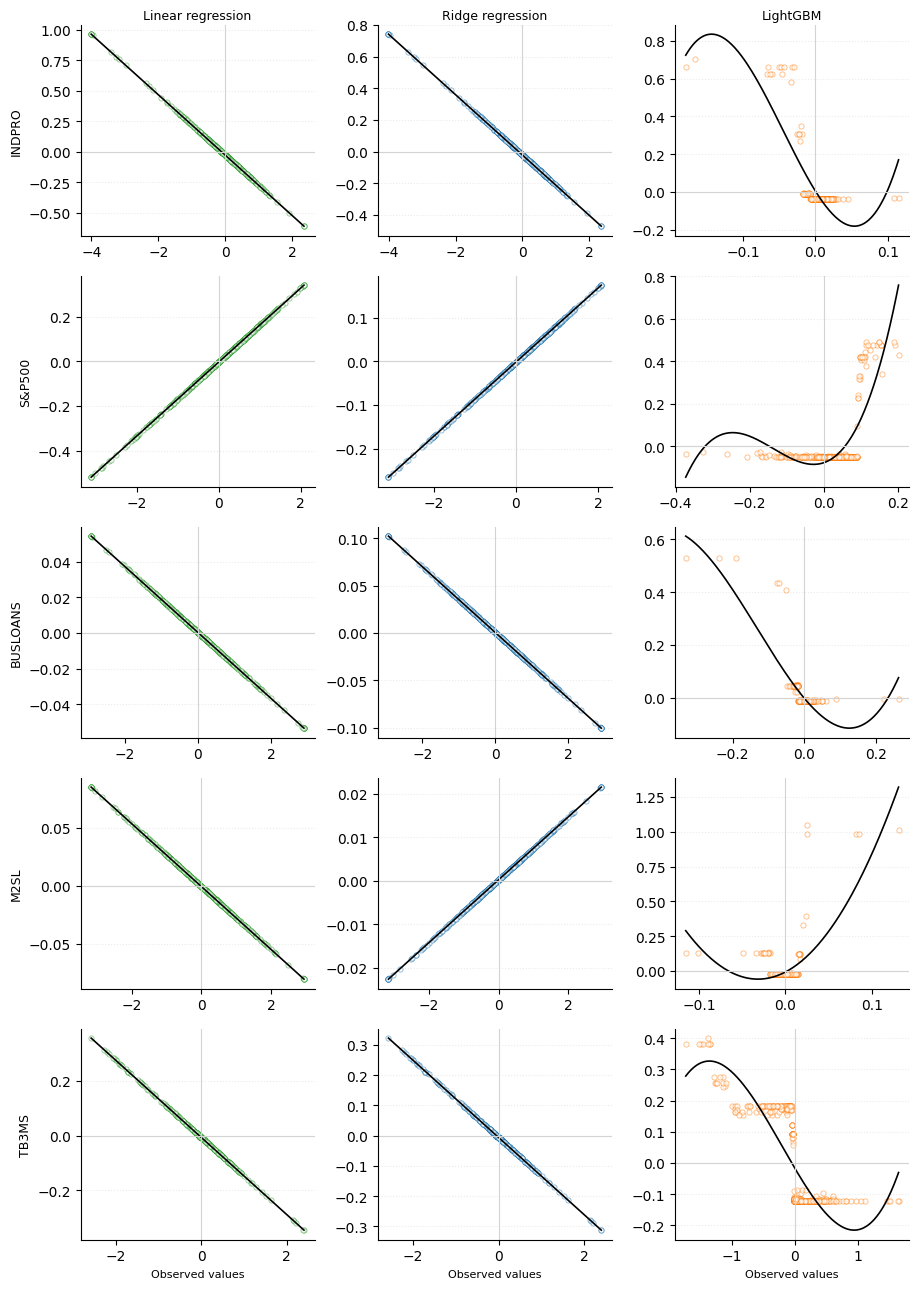

In [117]:
# ============================================================
# Functional-form plots — GRID (rows=variables, cols=models)
# Models: LinearRegression, Ridge (droites exactes), LightGBM (TreeExplainer)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor

# ---------------------- préproc "safe"
def _apply_prep(X: pd.DataFrame, prep):
    if prep is None:
        return X
    if hasattr(prep, "transform"):
        Xp = prep.transform(X)
        try:
            return pd.DataFrame(Xp, index=X.index, columns=X.columns)
        except Exception:
            return pd.DataFrame(Xp, index=X.index)
    Xp = X.copy()
    if isinstance(prep, dict):
        lower = prep.get("lower_wins", prep.get("lower", None))
        upper = prep.get("upper_wins", prep.get("upper", None))
        if lower is not None and upper is not None:
            lo = pd.Series(lower, index=Xp.columns) if not isinstance(lower, pd.Series) else lower.reindex(Xp.columns)
            up = pd.Series(upper, index=Xp.columns) if not isinstance(upper, pd.Series) else upper.reindex(Xp.columns)
            Xp = Xp.clip(lower=lo, upper=up, axis=1)
        if prep.get("norm", False):
            mean = prep.get("mean", None); std = prep.get("std", None)
            if mean is not None and std is not None:
                mean_s = pd.Series(mean, index=Xp.columns) if not isinstance(mean, pd.Series) else mean.reindex(Xp.columns)
                std_s  = pd.Series(std,  index=Xp.columns) if not isinstance(std,  pd.Series) else std.reindex(Xp.columns)
                Xp = (Xp - mean_s) / std_s.replace(0, 1)
    return Xp

# ---------------------- LightGBM helpers
def _lgbm_feature_names(model: LGBMRegressor):
    names = getattr(model, "feature_name_", None)
    if not names:
        booster = getattr(model, "_Booster", None)
        if booster is not None and hasattr(booster, "feature_name"):
            names = booster.feature_name()
    return list(names) if names else None

def _reorder_X_for_lgbm(model: LGBMRegressor, X: pd.DataFrame) -> pd.DataFrame:
    names = _lgbm_feature_names(model)
    if names:
        cols = [c for c in names if c in X.columns]
        return X.loc[:, cols]
    return X

# ---------------------- Extraction bundle (LGBM: ordre booster conservé)
def _get_model_from_bundle(bundle: dict, df_all: pd.DataFrame):
    if bundle is None or not isinstance(bundle, dict):
        raise ValueError("Bundle manquant ou invalide.")

    model_final = bundle["models"][-1] if isinstance(bundle.get("models"), (list, tuple)) and len(bundle["models"])>0 \
                  else bundle.get("model") or bundle.get("final_model")
    if model_final is None:
        raise KeyError("Impossible de trouver le modèle dans le bundle.")

    preprocs = bundle.get("preprocs", None)
    prep_final = preprocs[-1] if isinstance(preprocs, (list, tuple)) and len(preprocs)>0 else None

    features = (bundle.get("params", {}) or {}).get("features", None)
    if not features:
        features = _lgbm_feature_names(model_final) if isinstance(model_final, LGBMRegressor) \
                   else list(getattr(model_final, "feature_names_in_", []))
    if not features:
        raise KeyError("Features introuvables pour ce modèle.")

    end_time = df_all.index.max()
    if "train_fit_dates" in bundle:
        try:
            if len(bundle["train_fit_dates"])>0:
                end_time = pd.to_datetime(bundle["train_fit_dates"][-1])
        except Exception:
            pass

    X_full = df_all.loc[:end_time, features].copy().dropna(how="any")
    if isinstance(model_final, LGBMRegressor):
        X_full = _reorder_X_for_lgbm(model_final, X_full)

    return model_final, prep_final, X_full, list(X_full.columns)

# ---------------------- SHAP / contributions (retourne toujours ndarray)
def _compute_phi(model, X: pd.DataFrame, prep=None) -> np.ndarray:
    # --- LGBM : TreeExplainer
    if isinstance(model, LGBMRegressor):
        Xp = _apply_prep(_reorder_X_for_lgbm(model, X), prep).astype(float)
        expl = shap.TreeExplainer(model)
        sv = expl.shap_values(Xp, check_additivity=False)
        phi = sv[0] if isinstance(sv, list) else np.asarray(sv)
        if np.ndim(phi) == 3:
            phi = phi[0]
        if phi.shape[1] != Xp.shape[1]:
            raise ValueError("Dimensions SHAP incohérentes pour LGBM.")
        return np.asarray(phi)

    # --- Modèles linéaires : contributions EXACTES via coef_
    coef = getattr(model, "coef_", None)
    if coef is None:
        raise RuntimeError("Modèle linéaire attendu (coef_ manquant).")
    Xp = _apply_prep(X, prep).astype(float)
    mu = np.nanmean(Xp, axis=0)                  # baseline (moyenne)
    Xc = Xp - mu
    phi = Xc.to_numpy() * np.asarray(coef).reshape(1, -1)
    return phi

# ---------------------- Tracé en grille
def plot_functional_grid(models_dict, X_dict, selected_vars,
                         poly_deg_lgbm=3,             # degré pour LGBM
                         scatter_alpha=0.55, s=14,
                         colors=("tab:green","tab:blue","tab:orange"),
                         figsize_per_cell=(3.0, 2.6),
                         sharey=False):
    """
    - Lignes droites (deg=1) pour modèles linéaires (Linear/Ridge).
    - Lissage polynomiale (poly_deg_lgbm) pour LGBM.
    """
    model_names = list(models_dict.keys())

    # Intersection des index pour aligner temporellement
    common_index = None
    for m in model_names:
        idx = X_dict[m].index
        common_index = idx if common_index is None else common_index.intersection(idx)

    # Vérif features
    for v in selected_vars:
        for m in model_names:
            if v not in X_dict[m].columns:
                raise KeyError(f"'{v}' manquant dans les features du modèle {m}.")

    # Taille figure
    n_rows, n_cols = len(selected_vars), len(model_names)
    fig_w = n_cols * figsize_per_cell[0]
    fig_h = n_rows * figsize_per_cell[1]
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_w, fig_h), sharey=sharey)
    if n_rows == 1: axes = np.array([axes])
    if n_cols == 1: axes = axes.reshape(-1, 1)

    # Colonnes = modèles
    for c, (mname, (model, prep)) in enumerate(models_dict.items()):
        X_full = X_dict[mname].loc[common_index]
        phi = np.asarray(_compute_phi(model, X_full, prep=prep))  # robustesse
        is_linear = (hasattr(model, "coef_") and not isinstance(model, LGBMRegressor))
        deg = 1 if is_linear else poly_deg_lgbm
        color_pts = colors[c % len(colors)]

        # Abscisses du scatter : espace prétraité pour linéaires (droite parfaite)
        X_plot = _apply_prep(X_full, prep) if is_linear else X_full
        if isinstance(X_plot, pd.DataFrame):
            X_plot.columns = X_full.columns

        for r, feat in enumerate(selected_vars):
            ax = axes[r, c]
            j = X_full.columns.get_loc(feat)
            x = X_plot.iloc[:, j].to_numpy()
            y = phi[:, j]
            mask = ~(np.isnan(x) | np.isnan(y))
            x, y = x[mask], y[mask]

            # points
            ax.scatter(x, y, alpha=scatter_alpha, s=s,
                       facecolors="white", edgecolors=color_pts, linewidths=0.6)

            # courbe : droite pour linéaires, poly pour LGBM
            if len(x) > deg + 1:
                try:
                    coefs = np.polyfit(x, y, deg=deg)
                    x_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)
                    y_line = np.polyval(coefs, x_line)
                    ax.plot(x_line, y_line, color="black", linewidth=1.2)
                except Exception:
                    pass

            # habillage
            ax.axhline(0, color="lightgray", lw=0.8)
            ax.axvline(0, color="lightgray", lw=0.8)
            ax.grid(axis="y", linestyle=":", alpha=0.25)

            if r == 0: ax.set_title(mname, fontsize=9, pad=4)
            if c == 0: ax.set_ylabel(feat, fontsize=9)
            if r == n_rows - 1: ax.set_xlabel("Observed values", fontsize=8)
            for spine in ("top","right"): ax.spines[spine].set_visible(False)

    plt.tight_layout(h_pad=0.8, w_pad=0.8)
    return fig, axes

# ============================ USAGE ============================
# 1) Variables à tracer
selected_vars = ["INDPRO", "S&P500", "BUSLOANS", "M2SL", "TB3MS"]

# 2) Extraction (par bundle)
assert isinstance(df_stationary_test.index, pd.DatetimeIndex)
df_stationary_test = df_stationary_test.sort_index()

mdl_lin,   prep_lin,   X_lin,   _ = _get_model_from_bundle(linreg_bundle,  df_stationary_test)
mdl_ridge, prep_rdg,   X_rdg,   _ = _get_model_from_bundle(ridge_bundle,   df_stationary_test)
mdl_lgbm,  prep_lgbm,  X_lgbm,  _ = _get_model_from_bundle(lgbm_bundle,    df_stationary_test)

models_dict = {
    "Linear regression": (mdl_lin,  prep_lin),
    "Ridge regression":  (mdl_ridge,prep_rdg),
    "LightGBM":          (mdl_lgbm, prep_lgbm),
}
X_dict = {
    "Linear regression": X_lin,
    "Ridge regression":  X_rdg,
    "LightGBM":          X_lgbm,
}

# 3) Tracé
plt.style.use("default")
fig, axes = plot_functional_grid(
    models_dict=models_dict,
    X_dict=X_dict,
    selected_vars=selected_vars,
    poly_deg_lgbm=3,           # lissage uniquement pour LGBM
    figsize_per_cell=(3.1, 2.6),
    sharey=False
)
plt.show()


**Apport des variables dans l'explication du chômage pour la régression linéaire**
- BUSLOANS 📉 : une croissance des prêts bancaires aux entreprises, 12 mois plus tôt, favorise l’investissement et la création d’emplois → ralentit la hausse du chômage.
- S&P 500 📈 : une baisse du marché boursier (donc une performance négative il y a 12 mois) signale un ralentissement anticipé → entraîne une hausse du chômage l’année suivante.
- USREC 🏭 : un recul de l'activité économique → se traduit par plus de chômage après 12 mois.

**LightGBM :**
- Via la production industrielle, on constate clairement le cycle complet de l'économie. D’une part, lorsque l’activité augmente, les entreprises recrutent et le chômage diminue. D’autre part, au-delà d’un certain seuil, la surchauffe conduit à un ralentissement : les coûts augmentent, les marges se resserrent et le chômage repart à la hausse.
- L'effet de la masse monétaire est nouveau. La régression linéaire et RIDGE ne sont pas unanime sur son impact. Justement puisque, Pour de faibles niveaux de M2, l’augmentation de la masse monétaire stimule l’activité → le chômage baisse. Mais au-delà d’un certain seuil, la courbe remonte. Une expansion monétaire excessive coïncide avec une hausse du chômage, possiblement via des tensions inflationnistes. 
- Par ailleurs, on constate que TB3MS et M2SL évoluent en sens inverse. Une hausse du TB3MS traduit un resserrement monétaire qui freine la création de monnaie, tandis qu’une hausse du M2SL reflète une politique accommodante favorisant la liquidité et la croissance économique.

**Perspective finale**
- Comment on détermine exactement et concrètement ce point d'inflexion dans la relation non-linéaire? 